In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import AlgoLoop
import StatisticFunc

plt.style.use('Solarize_Light2')                     # 绘图风格
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 字体雅黑
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False    # 处理负号

# 预处理（剔除原油，铜，铁矿石）

## 提取并处理数据

### 各种利率

In [2]:
# GC007 利率
GCRates = pd.read_excel(io="Raw/GC007利率.xlsx")           #  读取数据
GCRates = GCRates.drop([0, 1, 2], axis=0)                   # 删除多余行
GCRates.columns = ['日期', 'GC007']                        # 修改列名
GCRates["日期"] = pd.DatetimeIndex(GCRates["日期"])           # 类型转换
GCRates = GCRates.set_index("日期")                          # 设置索引

In [3]:
# 10年国债收益率
CNRates = pd.read_excel(io="Raw/中债国债到期收益率(中债)(日).xls")        # 读取数据
CNRates.columns = ['日期', '十年国债收益率']                             # 修改列名
CNRates = CNRates.drop([0, 3870, 3871], axis=0)                       # 删除多余行
CNRates["日期"] = pd.DatetimeIndex(CNRates["日期"])                    # 类型转换
CNRates = CNRates.set_index("日期")                                   # 设置索引

In [4]:
# 10年美债收益率
USRates = pd.read_excel(io="Raw/美债收益率.xlsx")                       # 读取数据
USRates.columns = ['日期', '十年美债收益率']                             # 修改列名
USRates = USRates.drop([0, 6263, 6264], axis=0)                       # 删除多余行
USRates["日期"] = pd.DatetimeIndex(USRates["日期"])                    # 类型转换
USRates = USRates.set_index("日期")                                    # 设置索引

In [5]:
# 合并利率
Rates = GCRates.merge(CNRates, how='left', left_index=True, right_index=True)
Rates = Rates.merge(USRates, how='left', left_index=True, right_index=True)

In [6]:
Rates

GC007 十年国债收益率 十年美债收益率
日期                               
2008-01-02      3  4.4363    3.91
2008-01-03  2.815  4.4263    3.91
2008-01-04   2.85  4.4013    3.88
2008-01-07    2.7  4.3948    3.86
2008-01-08      2  4.4024    3.86
...           ...     ...     ...
2020-06-19   2.87  2.8752     0.7
2020-06-22  3.135  2.9153    0.71
2020-06-23  3.015  2.9127    0.72
2020-06-24   3.72  2.8614    0.69
2020-06-29   3.72     NaN    0.64

[3037 rows x 3 columns]

### 权益类资产换手率

In [7]:
Turnovers = pd.read_excel(io="Raw/资产换手率.xlsx")                      # 读取数据
Turnovers = Turnovers.drop([0], axis=0)                                   # 删除多余行
Turnovers["日期"] = pd.DatetimeIndex(Turnovers["日期"])                    # 类型转换
Turnovers = Turnovers.set_index("日期")                                   # 设置索引

In [8]:
# 时间对齐
Turnovers = Turnovers.loc[Rates.index, :]

### 各资产收盘价

In [9]:
Assets = pd.read_excel(io="Raw/资产收盘价.xlsx")
Assets = Assets.drop([0], axis=0)                                   # 删除多余行
Assets["日期"] = pd.DatetimeIndex(Assets["日期"])                    # 类型转换
Assets = Assets.set_index("日期")                                   # 设置索引

In [10]:
# 时间对齐
Assets = Assets.loc[Rates.index, :]

### 十年国债&美债价格指数

In [11]:
HoldPeriod = (Assets.index - Assets.index[0]).days

# 计算十年国债
Assets['10年国债'] = 100 - (Rates['十年国债收益率'] - 3.0) * 8.2 + 3.0 * HoldPeriod / 365.0
Assets['10年国债'] = Assets['10年国债'].fillna(method='ffill')

#计算十年美债
Assets['10年美债'] = 100 - (Rates['十年美债收益率'] - 3.0) * 8.2 + 3.0 * HoldPeriod / 365.0
Assets['10年美债'] = Assets['10年美债'].fillna(method='ffill')

In [12]:
# 替换上证十年国债指数
Assets = Assets.drop('上证10年国债', axis=1)
Assets

沪深300    中证500 信用债3-5AAA 中信证券COMEX铜期货 中信证券COMEX黄金期货 中信证券WTI原油期货  \
日期                                                                              
2008-01-02   5385.1  5123.93    99.689      7657.43        9302.4     10694.4   
2008-01-03  5422.03  5230.75    99.529       7943.2       9372.37     10614.9   
2008-01-04  5483.65  5243.03    99.568      7867.64       9336.21     10479.6   
2008-01-07  5556.59  5347.81    99.585       7817.5       9285.58       10166   
2008-01-08  5528.05  5200.55    99.448      8220.33       9495.24     10312.2   
...             ...      ...       ...          ...           ...         ...   
2020-06-19  4098.71  5787.15   200.598      5072.06       15459.5     746.671   
2020-06-22  4102.05  5784.03   200.394      5135.16       15567.2     763.025   
2020-06-23  4121.79  5804.34   200.015      5132.65       15661.6     754.211   
2020-06-24  4138.99  5789.09   199.981       5103.1       15575.4     708.954   
2020-06-29  4109.72  5762.44   200.232      5188.85         15685     743.131   

            中信证券铁矿石    标普500       10年国债       10年美债  
日期                                                    
2008-01-02      NaN  1447.16   88.222340   92.538000  
2008-01-03      NaN  1447.16   88.312559   92.546219  
2008-01-04      NaN  1411.63   88.525778   92.800438  
2008-01-07      NaN  1416.18   88.603736   92.989096  
2008-01-08      NaN  1390.19   88.549635   92.997315  
...             ...      ...         ...         ...  
2020-06-19  2536.27  3097.74  138.437059  156.273699  
2020-06-22  2500.06  3117.86  138.132896  156.216356  
2020-06-23  2486.89  3131.29  138.162435  156.142575  
2020-06-24  2518.16  3050.33  138.591315  156.396795  
2020-06-29  2462.21  3053.24  138.591315  156.847890  

[3037 rows x 10 columns]

### 美元汇率

In [13]:
FXRates = pd.read_excel(io="Raw/美元汇率.xlsx")
FXRates = FXRates.drop([0, 1, 2], axis=0)
FXRates.columns = ['日期', '美元汇率']                        
FXRates["日期"] = pd.DatetimeIndex(FXRates["日期"])
FXRates = FXRates.set_index("日期")

/Users/trevor/anaconda3/envs/myTensorflow/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


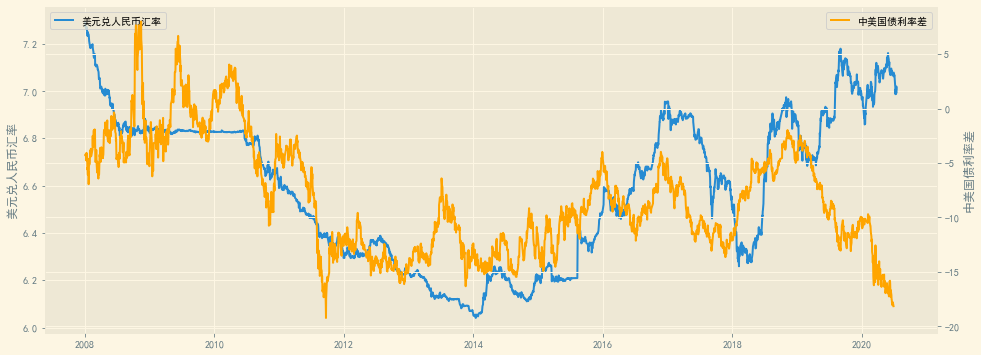

In [14]:
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(111)
ax1.plot(FXRates.index, FXRates['美元汇率'], label='美元兑人民币汇率')
ax1.set_ylabel('美元兑人民币汇率')
ax1.legend(loc='upper left')

ax2 = ax1.twinx() 
ax2.plot(Assets.index, (Assets['10年国债'] - Assets['10年美债']).values, color='orange', label='中美国债利率差')
ax2.set_ylabel('中美国债利率差')
ax2.set_xlabel('时间')
ax2.legend(loc='upper right')

plt.show()


In [15]:
# 皮尔逊相关系数
np.corrcoef( FXRates.values.flatten().astype(np.float32)[900:-233], 
             (Assets['10年国债'] - Assets['10年美债']).values.astype(np.float32)[900:-220] )

array([[1.        , 0.64462567],
       [0.64462567, 1.        ]])

## 计算各资产收益率

### 日内损益

- 去除WTI原油期货
- 去除COMEX铜期货
- 去除铁矿石期货

In [16]:
Returns = Assets.pct_change(axis=0)
Returns = Returns.dropna(axis=0, how='all')           # 删除无数据日

In [17]:
Returns = Returns.drop('中信证券WTI原油期货', axis=1)
Returns = Returns.drop('中信证券COMEX铜期货', axis=1)
Returns = Returns.drop('中信证券铁矿石', axis=1)

### 累计损益

In [18]:
cumReturns = (1.0 + Returns)
cumReturns = cumReturns.fillna(1.0)                    # 填充空值
cumReturns = cumReturns.cumprod()                      # 计算各资产累计收益率

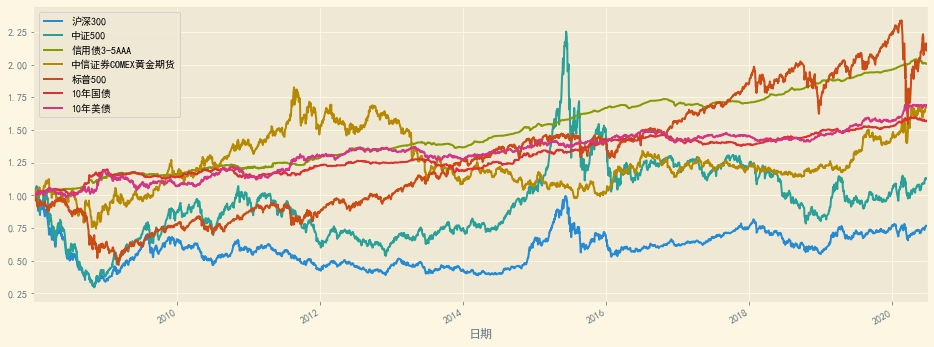

In [19]:
cumReturns.plot(figsize=(16, 6))

### 杠杆调整后的债券净值

In [20]:
lever = 2.0                                 # 杠杆（额外）
leverReturns = Returns.copy()               # 创建副本 
leverCumReturns = cumReturns.copy()   

In [21]:
# 更新杠杆调整后的债券净值
leverReturns['10年国债'] = Returns['10年国债'] * (1.0 + lever) - Rates.loc[Returns.index, 'GC007'] * lever / (365.0 * 100)
leverReturns['信用债3-5AAA'] = Returns['信用债3-5AAA'] * (1.0 + lever) - Rates.loc[Returns.index, 'GC007'] * lever / (365.0 * 100)

# 更新累计净值
leverCumReturns = (1.0 + leverReturns)
leverCumReturns = leverCumReturns.fillna(1.0)                    # 填充空值
leverCumReturns = leverCumReturns.cumprod()                      # 计算各资产累计收益率

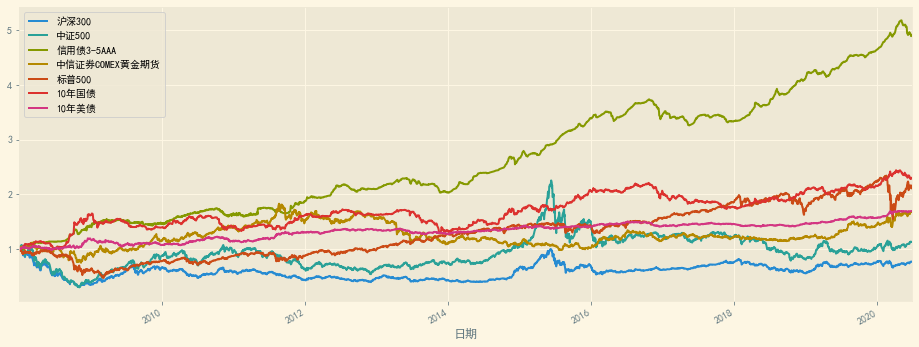

In [22]:
leverCumReturns.plot(figsize=(16, 6))

# 风险平价 + 杠杆策略（指数权重EMA）

## 程序运行

In [23]:
tradeDF, weightDF = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, FXRates, mode='ema')

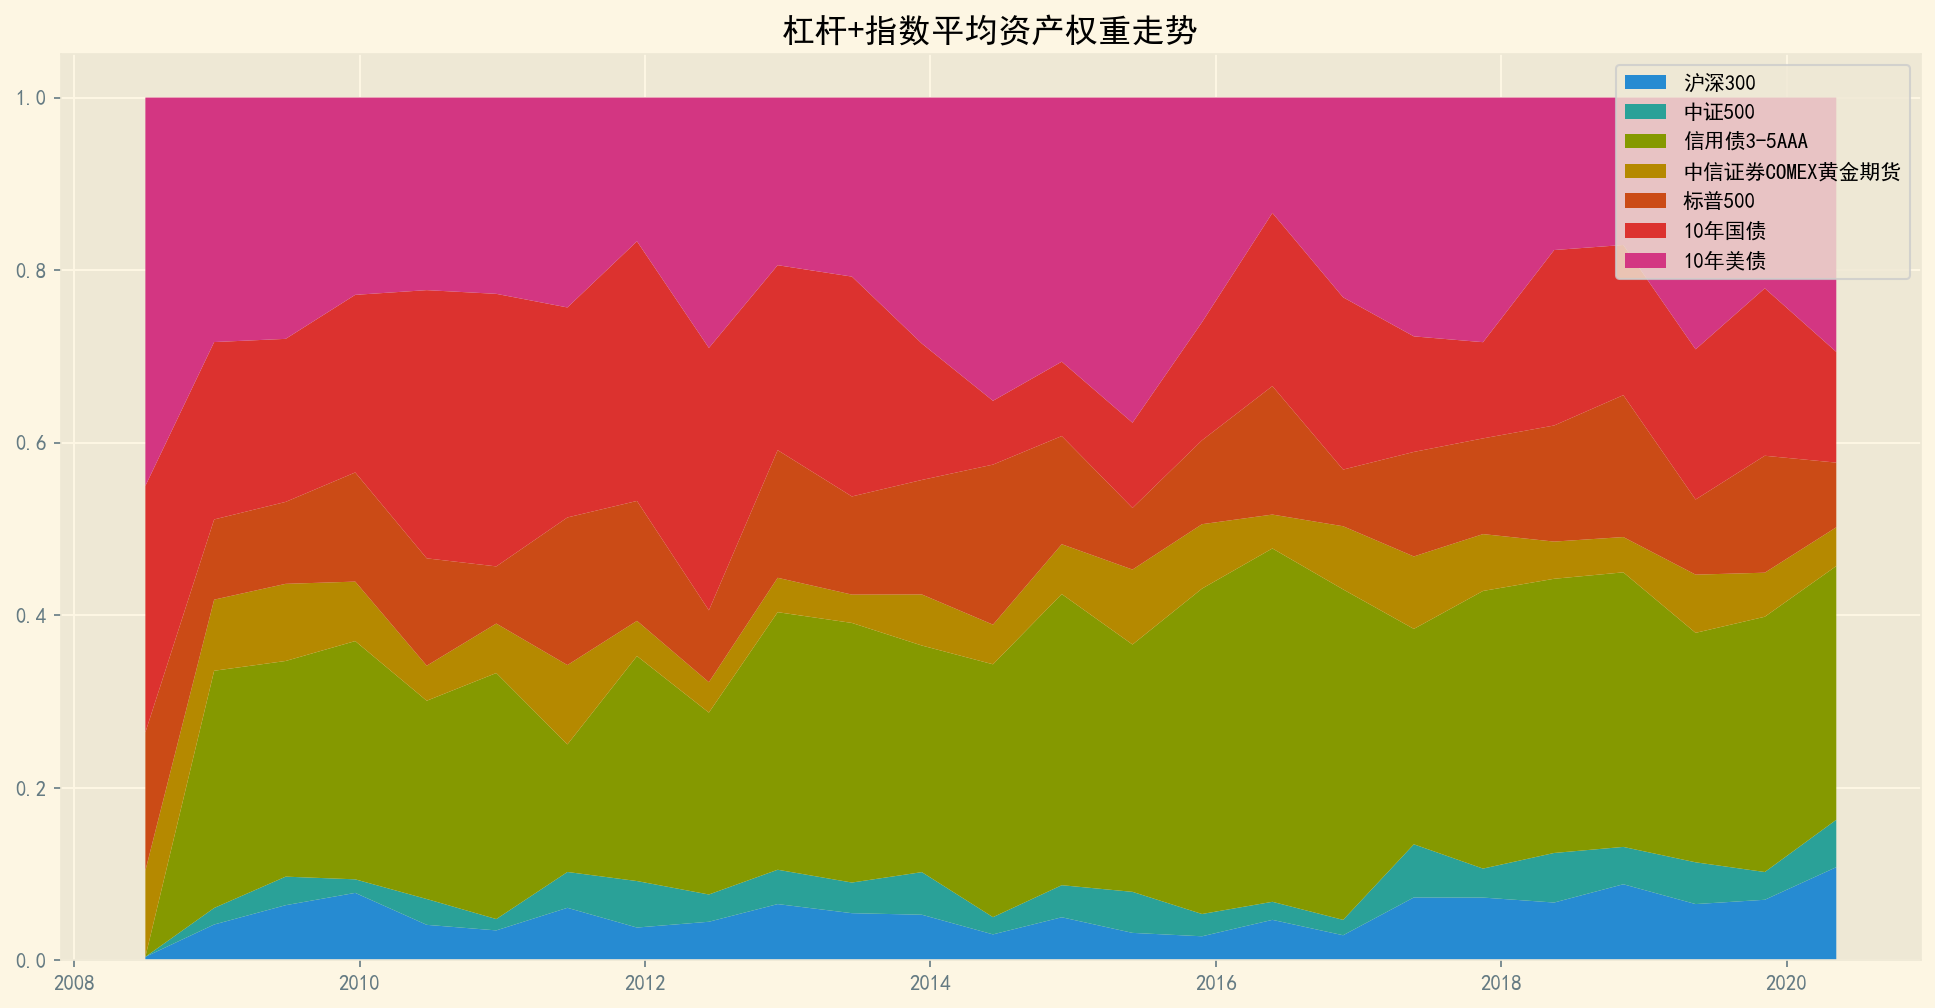

In [24]:
StatisticFunc.WeightPlot(tradeDF, weightDF, '杠杆+指数平均')

## 回测表现汇总

In [33]:
smryDF = StatisticFunc.summaryDF(tradeDF)
pfmcDF = StatisticFunc.performanceDF(smryDF, tradeDF)

In [34]:
smryDF

年收益率      年波动率       信息比      最大回撤
2008    0.200773  0.089616   2.24038 -0.026002
2009   0.0599853  0.065818  0.911387 -0.033627
2010     0.06386  0.050125   1.27402 -0.062468
2011   0.0809654  0.059791   1.35415 -0.076954
2012   0.0670996  0.034145   1.96512 -0.029975
2013  -0.0441746  0.049607 -0.890491 -0.106167
2014    0.182621  0.032443   5.62891 -0.107713
2015    0.148627  0.043693   3.40162 -0.031350
2016   0.0278491  0.035388  0.786964 -0.071259
2017  0.00323524  0.026264  0.123181 -0.079700
2018   0.0405013  0.036361   1.11385 -0.060346
2019    0.151853  0.033043   4.59563 -0.022244
2020   0.0555399  0.067802  0.819152 -0.051023

In [35]:
pfmcDF

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.079903  0.048007 -0.107713     505.0  1.664385  0.741812

## 收益率贡献度

In [29]:
annualContrb = StatisticFunc.AnnualContribution(tradeDF=tradeDF, weightDF=weightDF, assetDF=leverCumReturns)

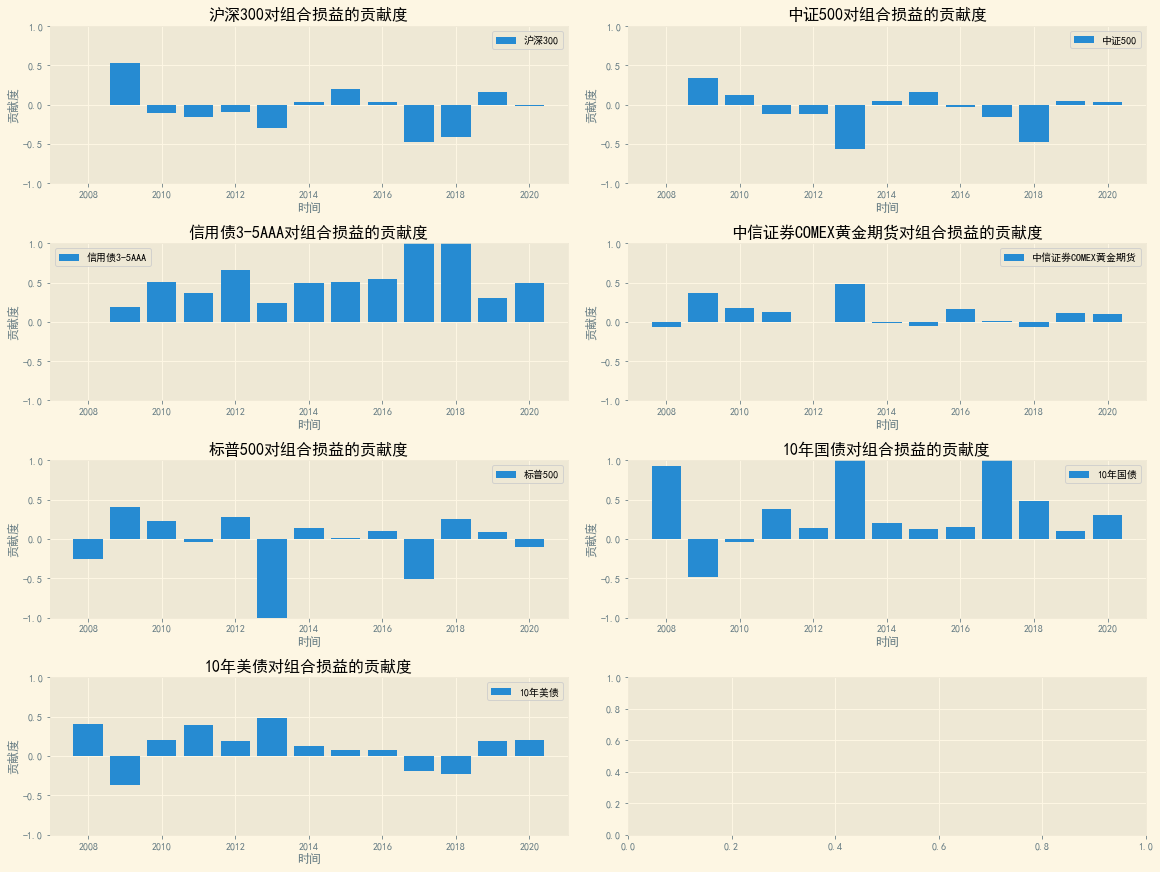

In [30]:
StatisticFunc.BarPlot(annualContrb, '杠杆+指数平均')

## 投资组合净值曲线

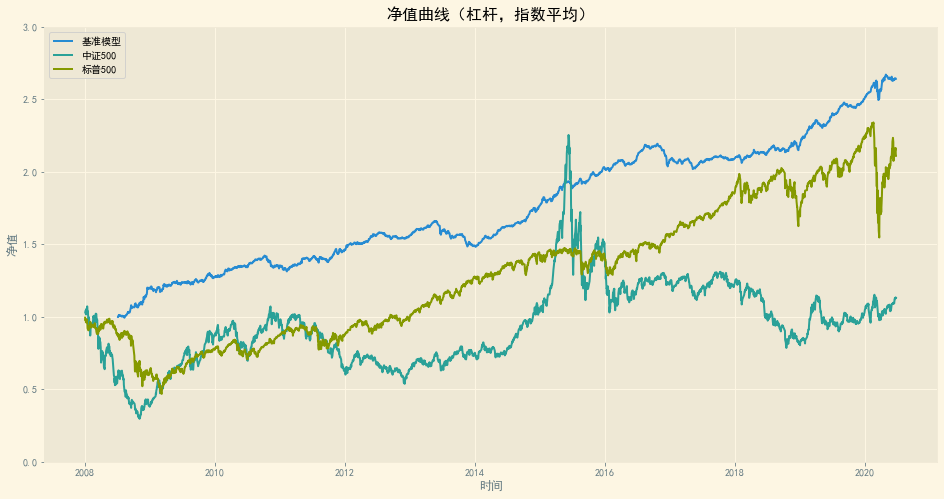

In [137]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, label='基准模型')
    
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['标普500'], label='标普500')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线（杠杆，指数平均）')
plt.savefig('Pics/净值曲线（杠杆，指数平均）.png')

# 风险平价 + 杠杆 + 多因子策略（指数平均）

## 横截面动量+时序动量+换手率+铜金+铜油（基准）

### 程序运行

In [36]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 'fxRate':False,
            'copperGold':True, 'copperGas':True}

tradeDF_multi, weightDF_multi = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, FXRates, 
                                                   mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

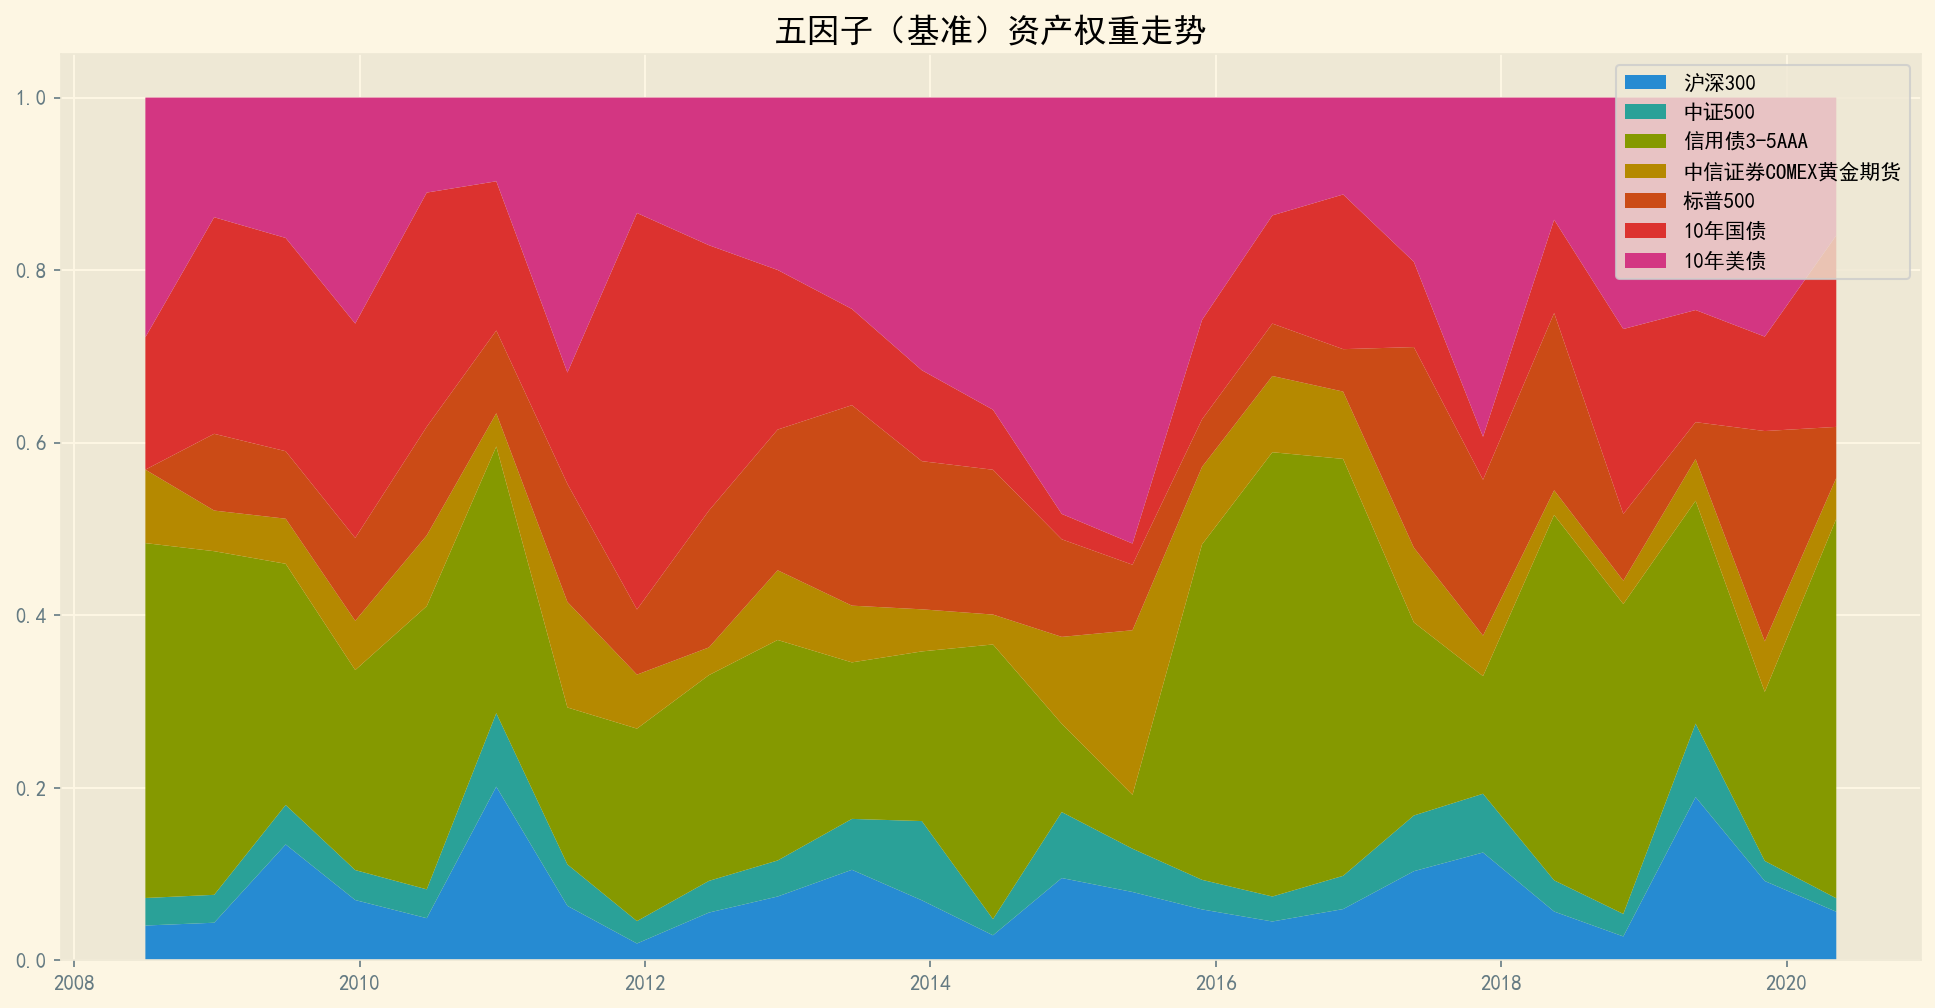

In [37]:
StatisticFunc.WeightPlot(tradeDF_multi, weightDF_multi, '五因子（基准）')

### 回测表现汇总

In [38]:
smryDF_multi = StatisticFunc.summaryDF(tradeDF_multi)
pfmcDF_multi = StatisticFunc.performanceDF(smryDF_multi, tradeDF_multi)

In [39]:
smryDF_multi

年收益率      年波动率        信息比      最大回撤
2008    0.217932  0.098494    2.21266 -0.038776
2009   0.0789648  0.080054   0.986396 -0.043401
2010    0.062777  0.053839    1.16602 -0.066411
2011   0.0534215  0.068145   0.783942 -0.080389
2012   0.0598606  0.037543    1.59446 -0.030321
2013 -0.00189233  0.053547 -0.0353397 -0.064929
2014    0.177245  0.034527    5.13352 -0.060771
2015    0.127498  0.067500    1.88887 -0.063030
2016   0.0174316  0.039294    0.44362 -0.080051
2017    0.013624  0.030173   0.451538 -0.094341
2018    0.052119  0.040404    1.28995 -0.071421
2019    0.124679  0.036739    3.39369 -0.020694
2020  0.00783412  0.106312  0.0736898 -0.083462

In [40]:
pfmcDF_multi

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.076269  0.057428 -0.094341     516.0  1.328071  0.808437

### 收益率贡献度

In [41]:
annualContrb_multi = StatisticFunc.AnnualContribution(tradeDF=tradeDF_multi, 
                                                      weightDF=weightDF_multi, 
                                                      assetDF=leverCumReturns)

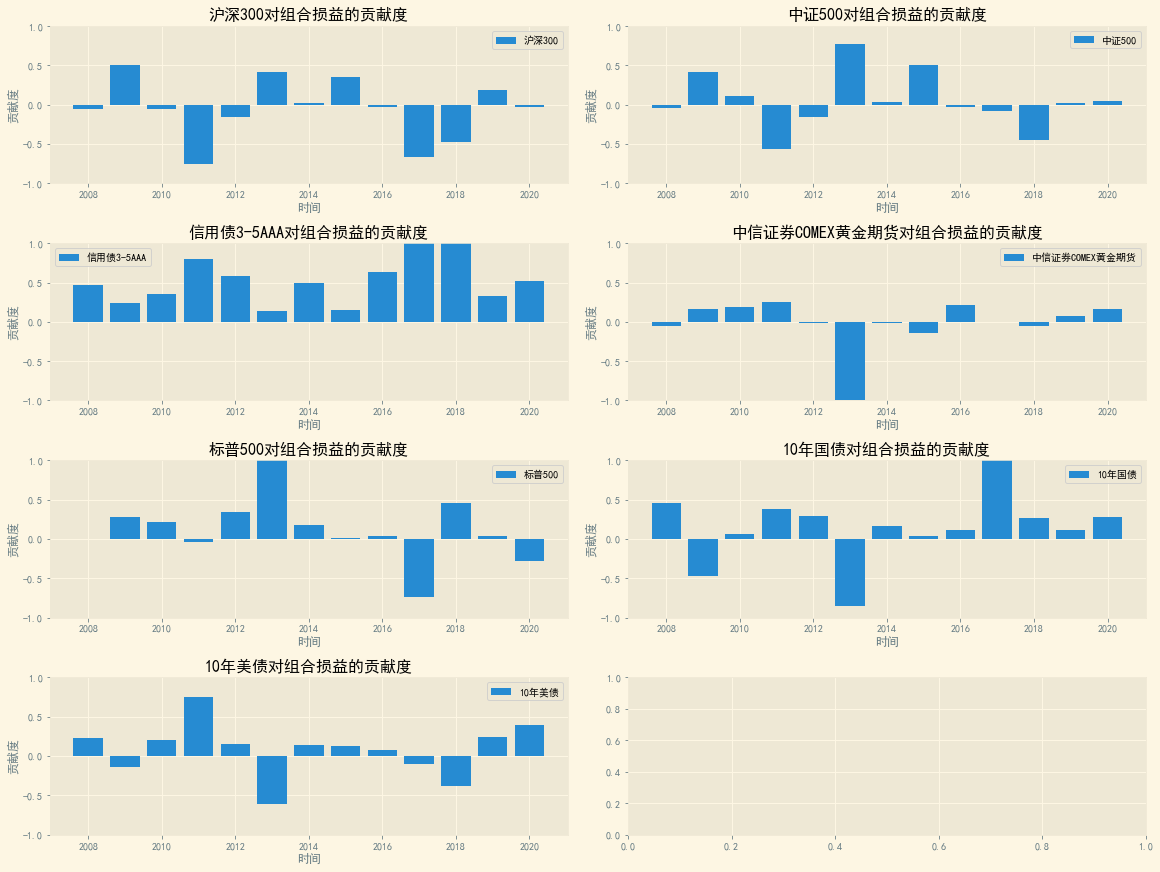

In [42]:
StatisticFunc.BarPlot(annualContrb_multi, '五因子（基准）')

### 投资组合净值曲线

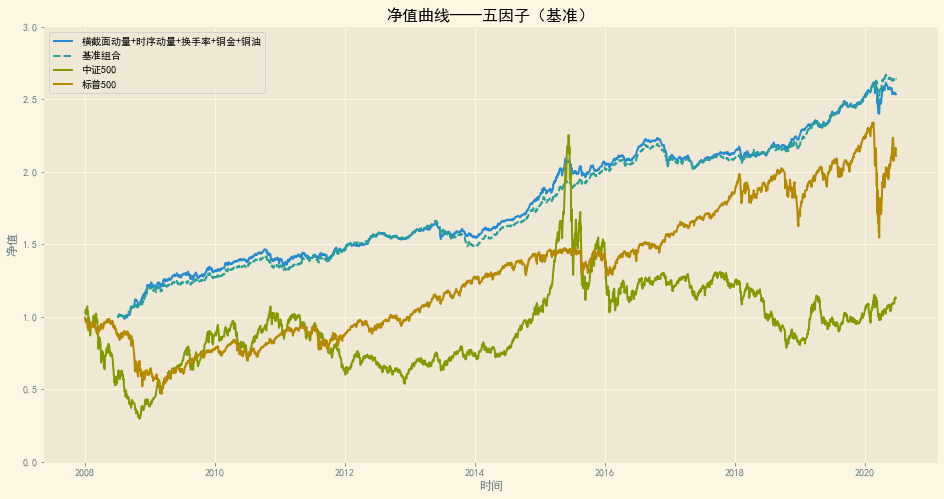

In [43]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_multi.index, tradeDF_multi['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜金+铜油')
    
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='基准组合') 
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['标普500'], label='标普500')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线——五因子（基准）')
plt.savefig('Pics/净值曲线——五因子（基准）.png')

## 横截面动量+时序动量+换手率+铜金+铜油+汇率（基准）

### 程序运行

In [44]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 'fxRate':True,
            'copperGold':True, 'copperGas':True}

tradeDF_multi2, weightDF_multi2 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, FXRates, 
                                                   mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

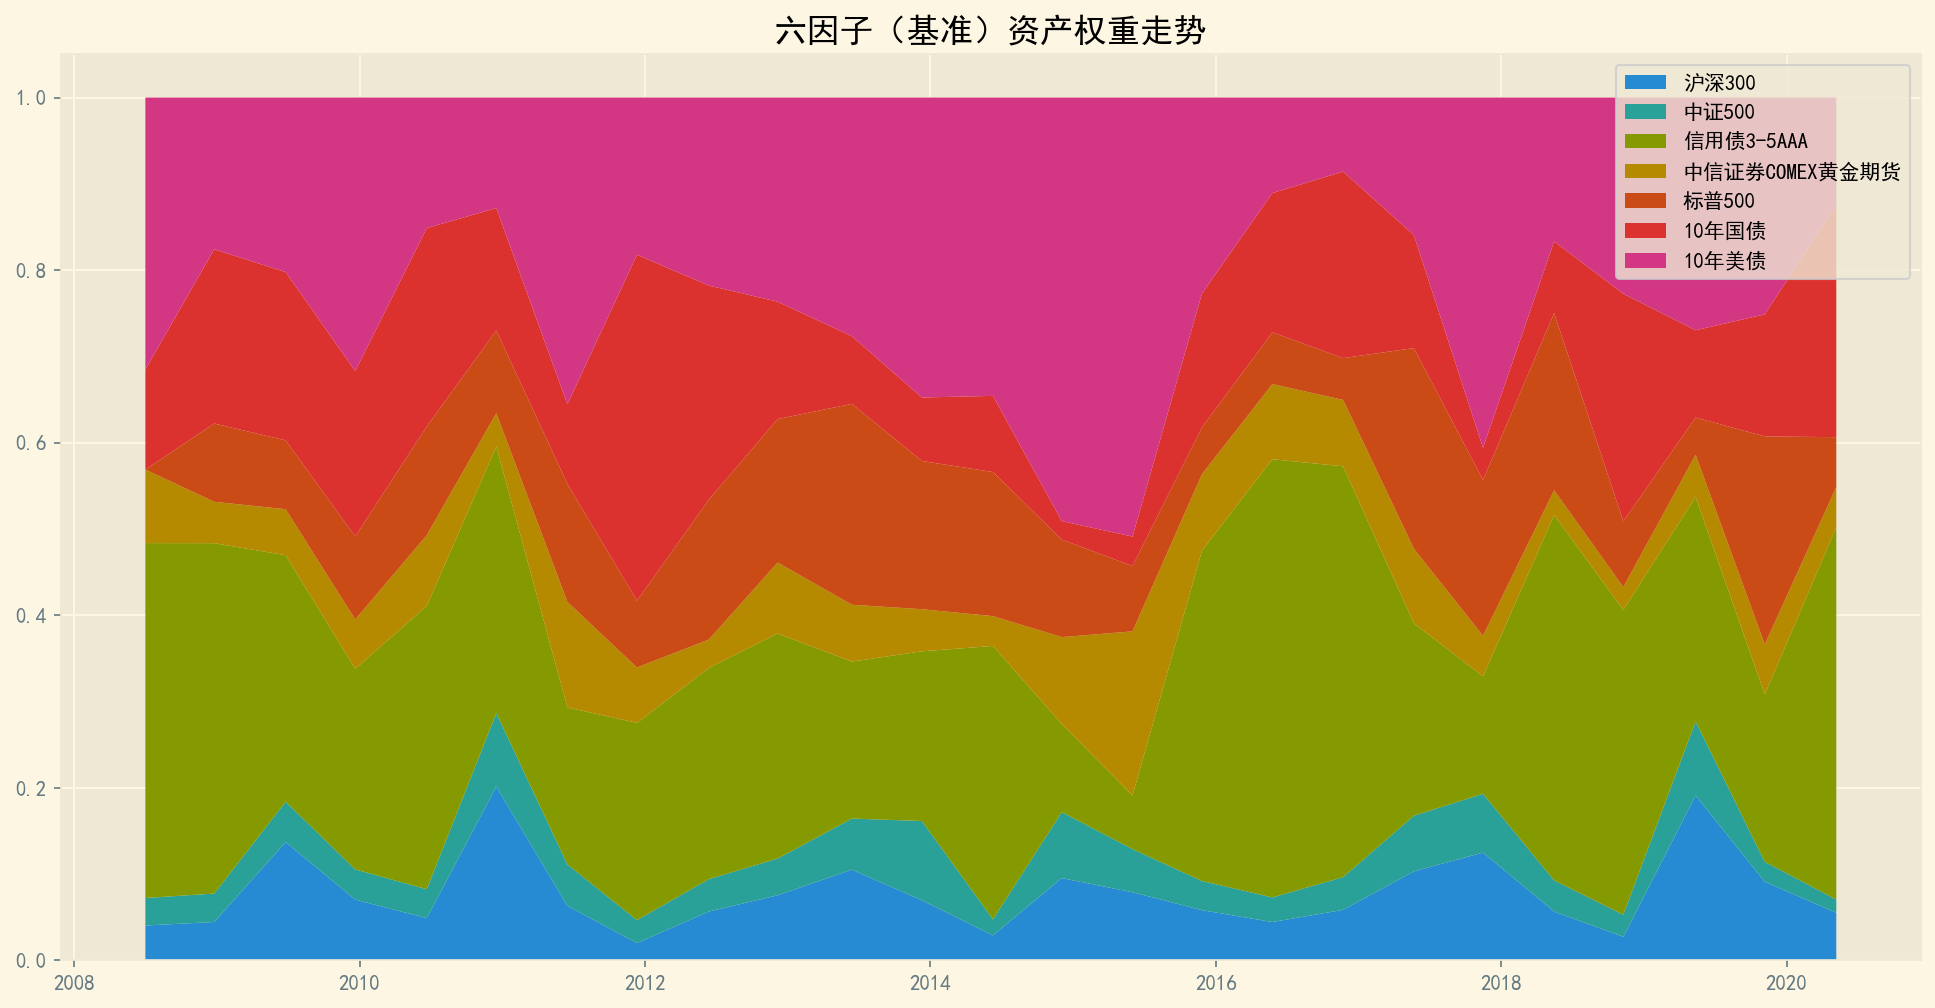

In [45]:
StatisticFunc.WeightPlot(tradeDF_multi2, weightDF_multi2, '六因子（基准）')

### 回测表现汇总

In [46]:
smryDF_multi2 = StatisticFunc.summaryDF(tradeDF_multi2)
pfmcDF_multi2 = StatisticFunc.performanceDF(smryDF_multi2, tradeDF_multi2)

In [47]:
smryDF_multi2

年收益率      年波动率        信息比      最大回撤
2008     0.20149  0.096497    2.08805 -0.039541
2009   0.0850163  0.080005    1.06264 -0.043885
2010   0.0642911  0.052431    1.22621 -0.065059
2011   0.0518773  0.067652   0.766825 -0.078013
2012   0.0619909  0.035940    1.72485 -0.027819
2013  0.00116275  0.053052  0.0219173 -0.065410
2014    0.175673  0.034578     5.0805 -0.055603
2015    0.131053  0.067385    1.94483 -0.061990
2016   0.0165595  0.040067   0.413296 -0.082881
2017  0.00721012  0.030991    0.23265 -0.099101
2018   0.0508305  0.040632    1.25099 -0.078363
2019     0.12452  0.037530    3.31791 -0.023469
2020  0.00811539  0.105630  0.0768284 -0.081927

In [48]:
pfmcDF_multi2

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.075368  0.057107 -0.099101     536.0  1.319779  0.760524

### 收益率贡献度

In [49]:
annualContrb_multi2 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_multi2, 
                                                      weightDF=weightDF_multi2, 
                                                      assetDF=leverCumReturns)

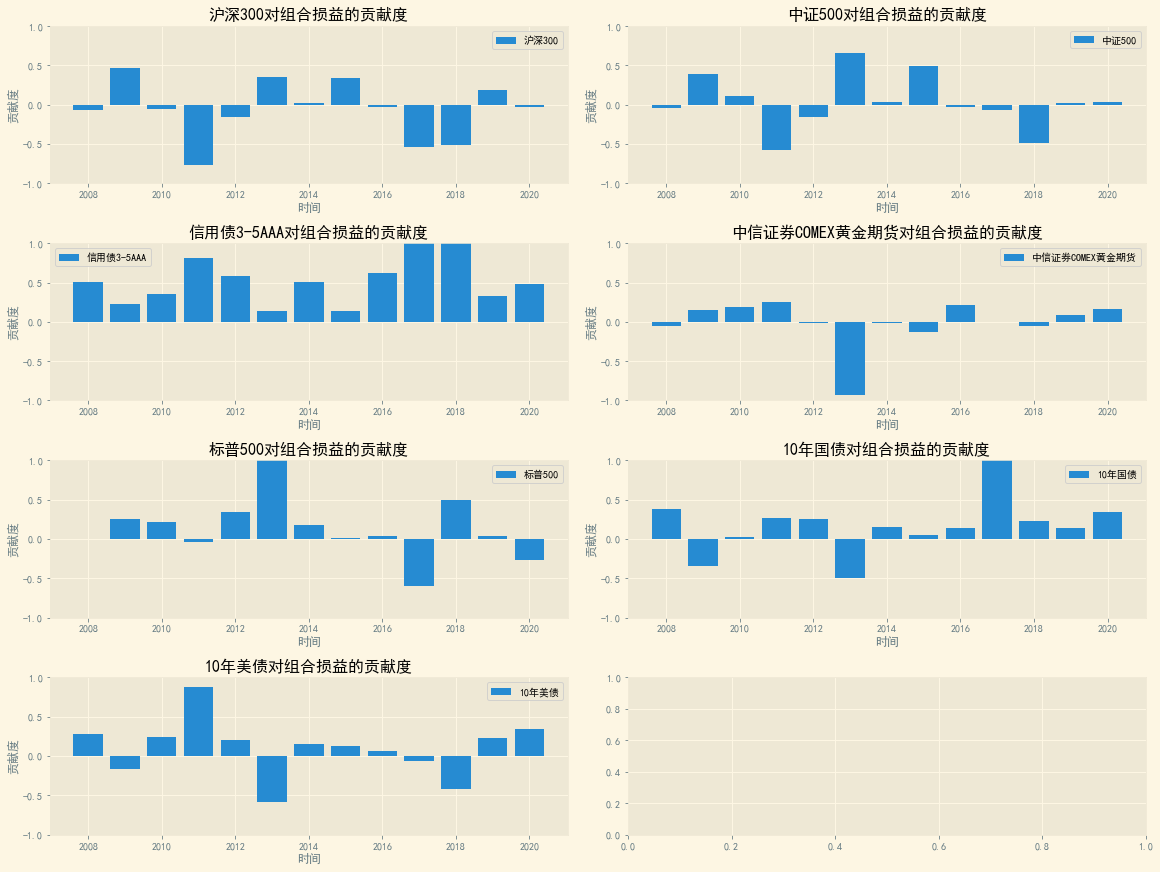

In [50]:
StatisticFunc.BarPlot(annualContrb_multi2, '六因子（基准）')

### 投资组合净值曲线

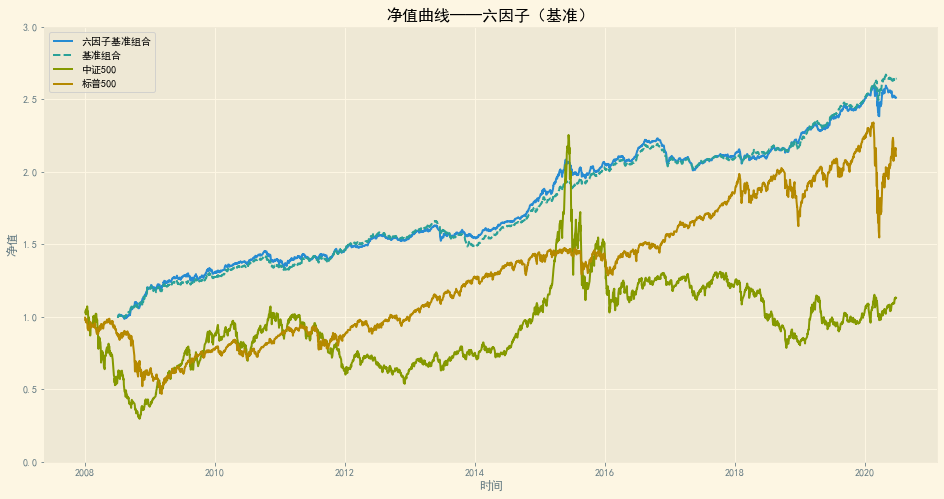

In [51]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_multi2.index, tradeDF_multi2['投资组合净值']/10000, label='六因子基准组合')
    
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='基准组合') 
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['标普500'], label='标普500')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线——六因子（基准）')
plt.savefig('Pics/净值曲线——六因子（基准）.png')

## 横截面动量+时序动量+换手率+铜金+铜油+汇率（去除沪深300）

In [52]:
leverReturns_A    = leverReturns.drop('沪深300', axis=1)
leverCumReturns_A = leverCumReturns.drop('沪深300', axis=1)

### 程序运行

In [53]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 'fxRate':True,
            'copperGold':True, 'copperGas':True}

tradeDF_A, weightDF_A = AlgoLoop.AlgoTrade(Assets, leverReturns_A, leverCumReturns_A, Turnovers, FXRates, 
                                           mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

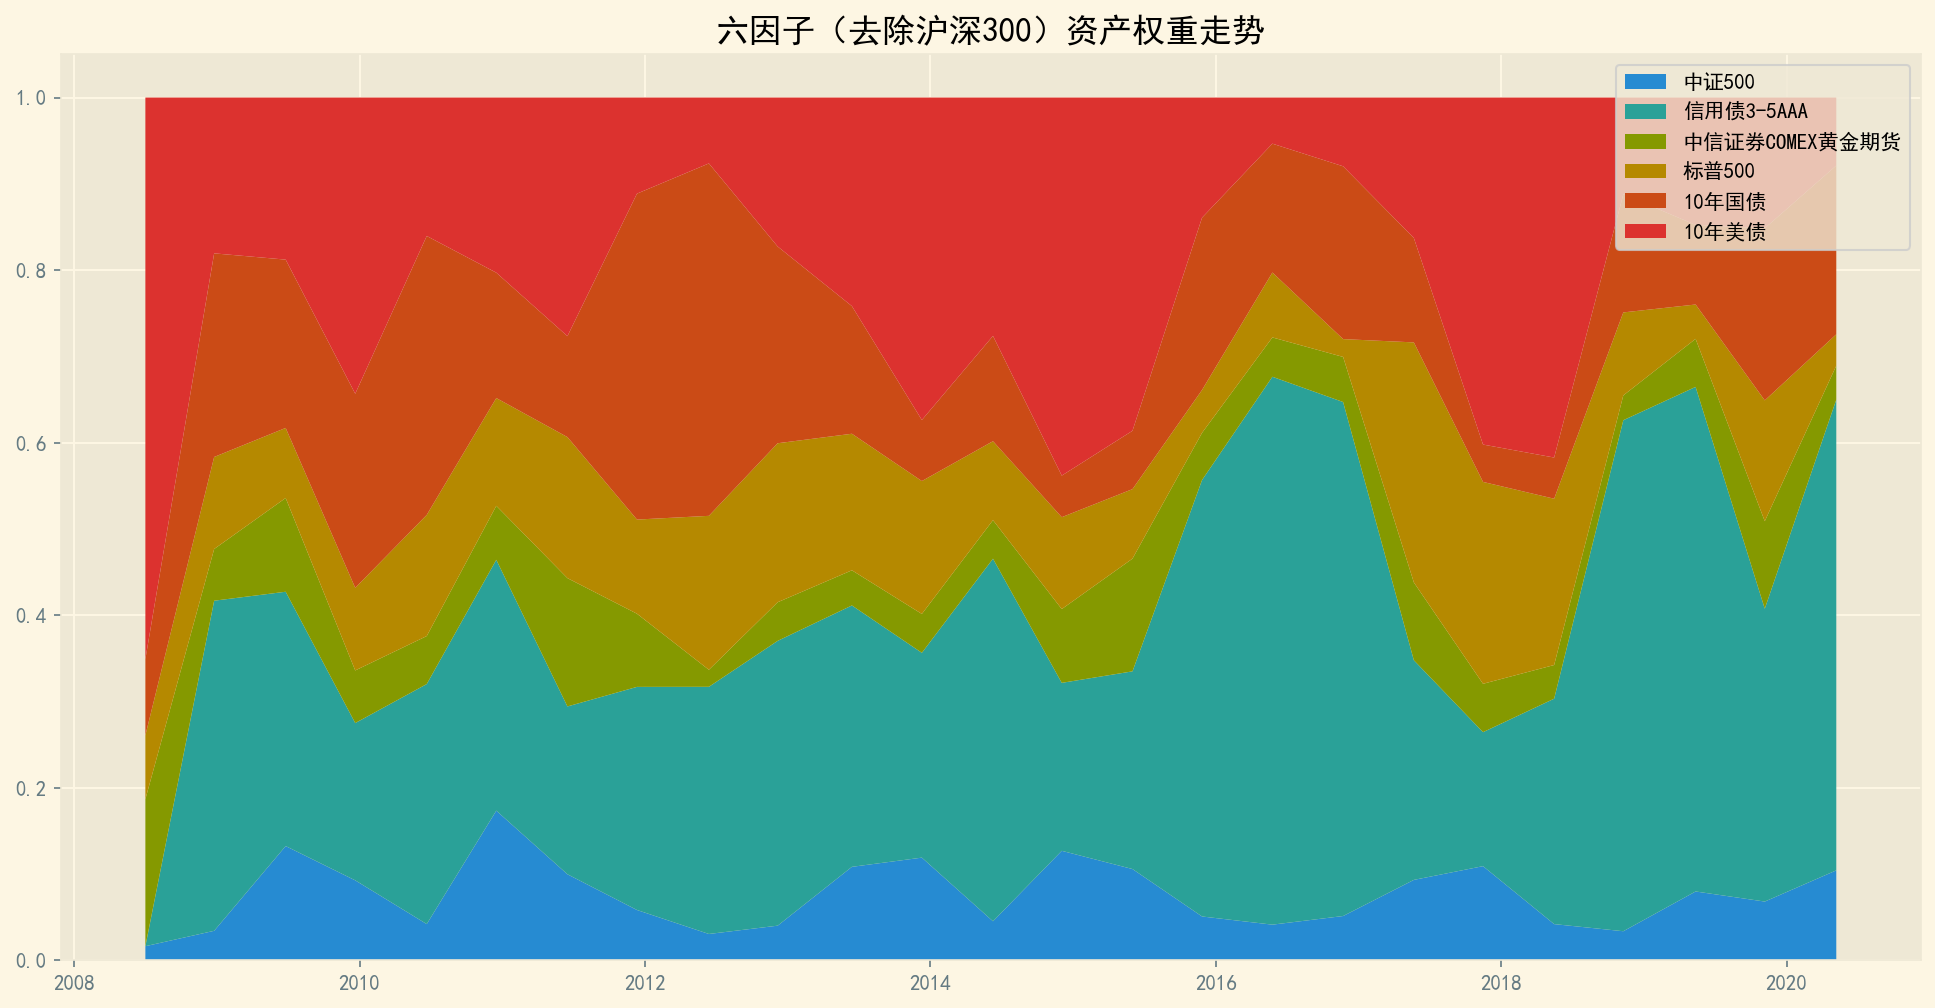

In [54]:
StatisticFunc.WeightPlot(tradeDF_A, weightDF_A, '六因子（去除沪深300）')

### 回测表现汇总

In [55]:
smryDF_A = StatisticFunc.summaryDF(tradeDF_A)
pfmcDF_A = StatisticFunc.performanceDF(smryDF_A, tradeDF_A)

In [56]:
smryDF_A 

年收益率      年波动率        信息比      最大回撤
2008    0.128439  0.088337    1.45396 -0.050632
2009   0.0669095  0.076664   0.872766 -0.040363
2010   0.0638436  0.051058    1.25041 -0.070141
2011   0.0569371  0.064092   0.888361 -0.082651
2012   0.0620563  0.037941    1.63559 -0.033278
2013 -0.00054389  0.046036 -0.0118145 -0.068878
2014    0.176396  0.033027    5.34102 -0.071177
2015    0.185504  0.056557    3.27993 -0.042092
2016   0.0165114  0.037845   0.436291 -0.087178
2017  -0.0140818  0.030287  -0.464952 -0.112079
2018   0.0388691  0.037364    1.04028 -0.101500
2019    0.127905  0.024880    5.14087 -0.035506
2020   0.0440192  0.076112   0.578344 -0.051700

In [57]:
pfmcDF_A

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.07329  0.050785 -0.112079     564.0  1.443145   0.65391

### 收益率贡献度

In [58]:
annualContrb_A = StatisticFunc.AnnualContribution(tradeDF=tradeDF_multi, 
                                                      weightDF=weightDF_multi, 
                                                      assetDF=leverCumReturns_A)

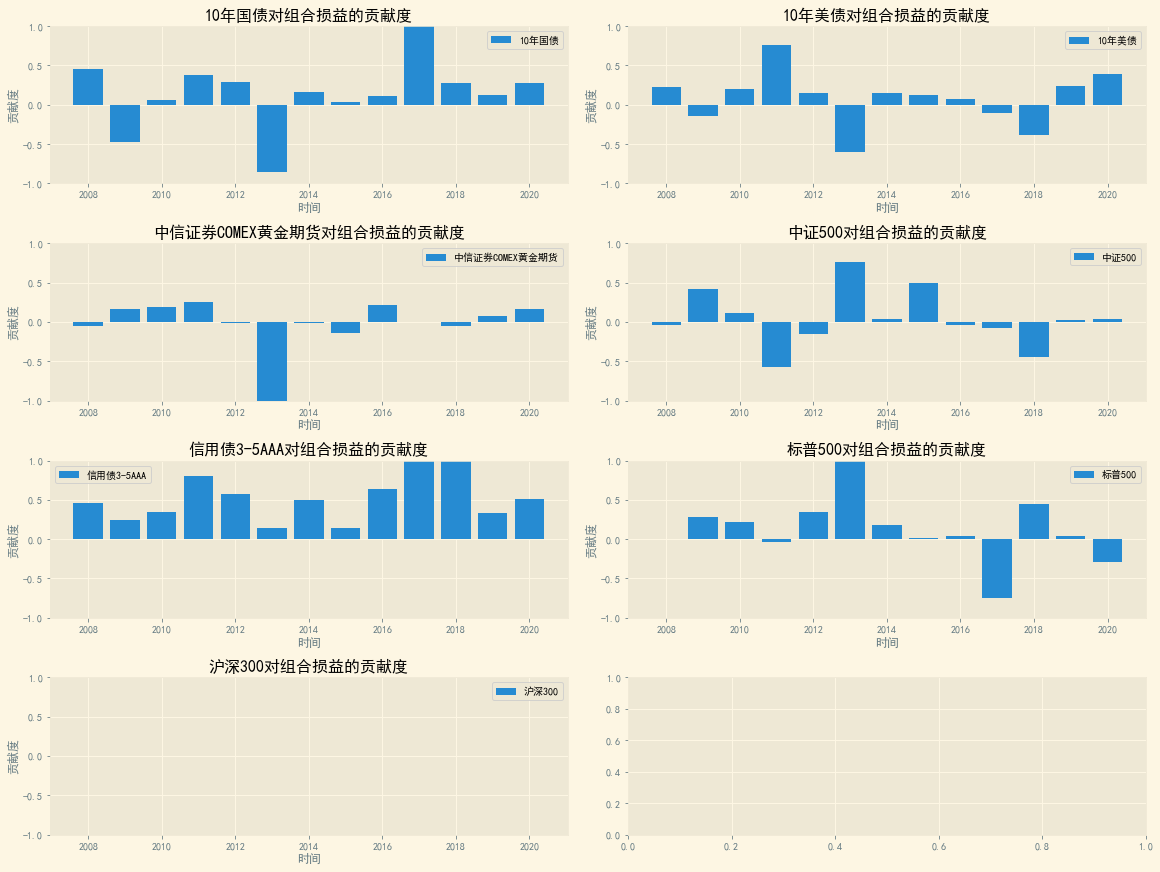

In [59]:
StatisticFunc.BarPlot(annualContrb_A, '六因子（去除沪深300）')

### 投资组合净值曲线

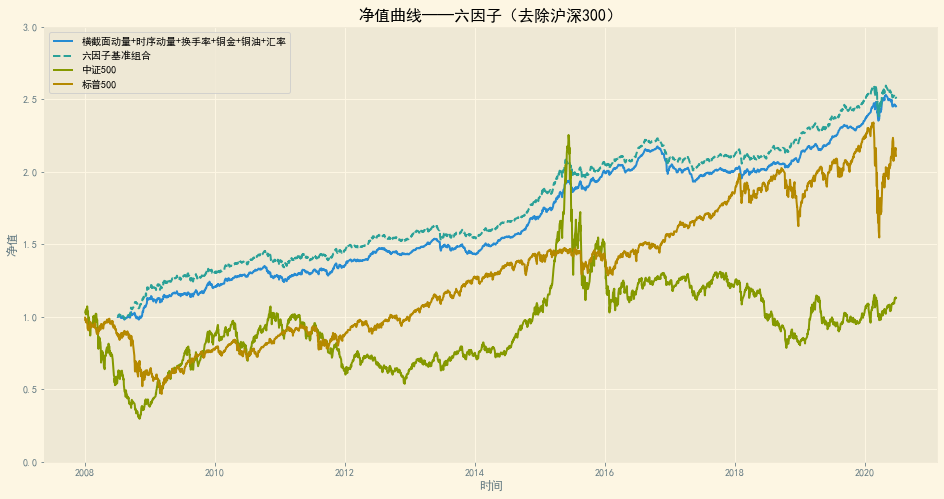

In [60]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_A.index, tradeDF_A['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜金+铜油+汇率')
    
plt.plot(tradeDF_multi2.index, tradeDF_multi2['投资组合净值']/10000, ls='--', label='六因子基准组合')    
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['标普500'], label='标普500')


plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线——六因子（去除沪深300）')
plt.savefig('Pics/净值曲线——六因子（去除沪深300）.png')

## 横截面动量+时序动量+换手率+铜金+铜油+汇率（去除中证500）

In [61]:
leverReturns_B    = leverReturns.drop('中证500', axis=1)
leverCumReturns_B = leverCumReturns.drop('中证500', axis=1)

### 程序运行

In [62]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 'fxRate':True,
            'copperGold':True, 'copperGas':True}

tradeDF_B, weightDF_B = AlgoLoop.AlgoTrade(Assets, leverReturns_B, leverCumReturns_B, Turnovers, FXRates, 
                                           mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

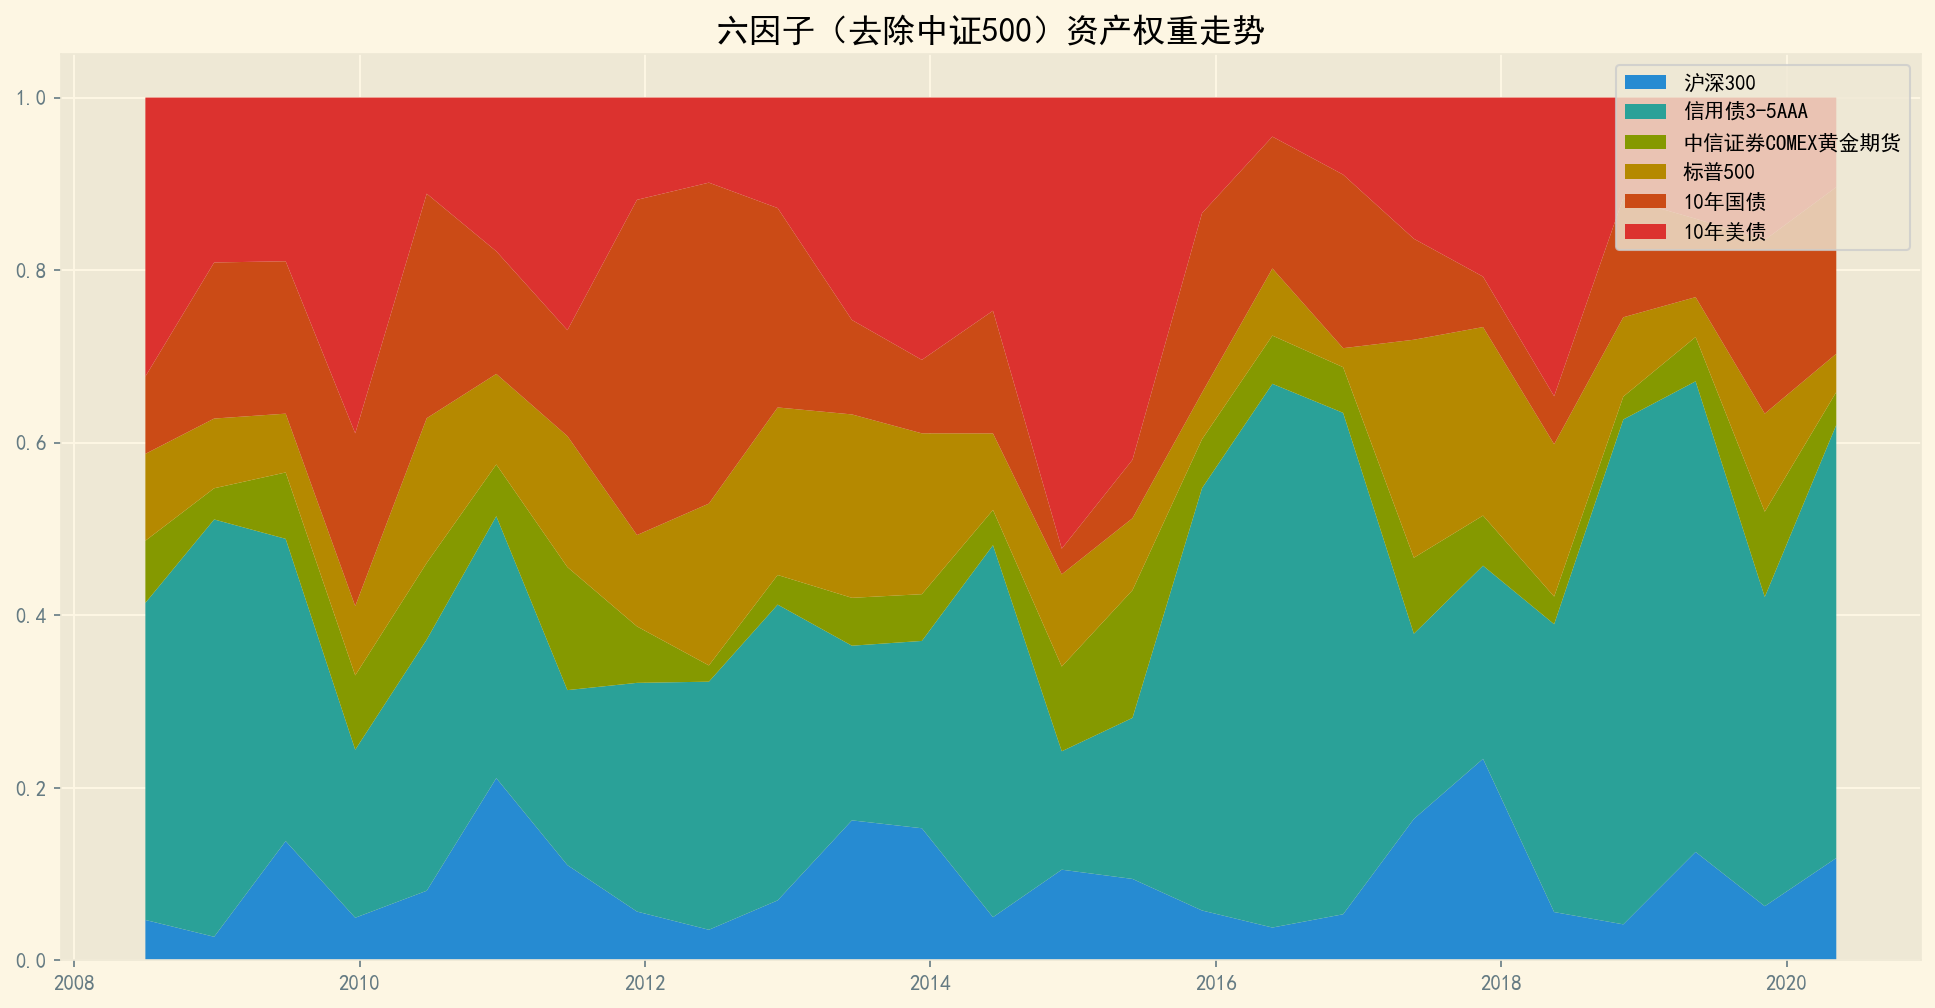

In [63]:
StatisticFunc.WeightPlot(tradeDF_B, weightDF_B, '六因子（去除中证500）')

### 回测表现汇总

In [64]:
smryDF_B = StatisticFunc.summaryDF(tradeDF_B)
pfmcDF_B = StatisticFunc.performanceDF(smryDF_B, tradeDF_B)

In [65]:
smryDF_B

年收益率      年波动率       信息比      最大回撤
2008    0.155156  0.081876   1.89502 -0.040550
2009   0.0385484  0.074693  0.516091 -0.034352
2010   0.0835371  0.051378   1.62592 -0.056750
2011   0.0659255  0.064766    1.0179 -0.064270
2012   0.0704432  0.037030   1.90233 -0.031921
2013  0.00820237  0.050245  0.163248 -0.062369
2014    0.190276  0.033604   5.66226 -0.066132
2015    0.107318  0.051751   2.07372 -0.035275
2016   0.0186553  0.037686  0.495018 -0.085766
2017  0.00986936  0.031714  0.311201 -0.105430
2018    0.058594  0.042559   1.37677 -0.071276
2019    0.135393  0.025540   5.30114 -0.018295
2020   0.0479945  0.066629  0.720325 -0.046936

In [66]:
pfmcDF_B

年化收益     年化波动率     最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.076147  0.049959 -0.10543     513.0  1.524183  0.722254

### 收益率贡献度

In [67]:
annualContrb_B = StatisticFunc.AnnualContribution(tradeDF=tradeDF_multi, 
                                                      weightDF=weightDF_multi, 
                                                      assetDF=leverCumReturns_B)

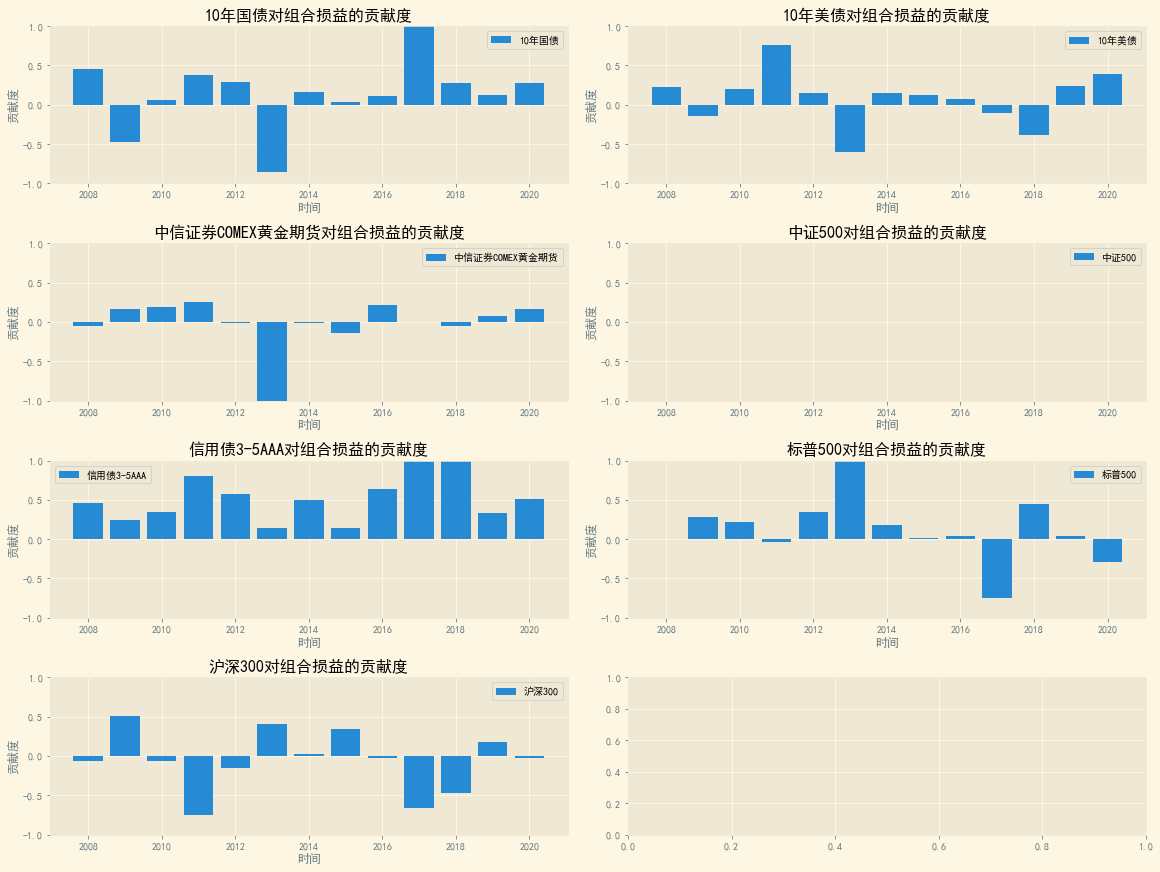

In [68]:
StatisticFunc.BarPlot(annualContrb_B, '六因子（去除中证500）')

### 投资组合净值曲线

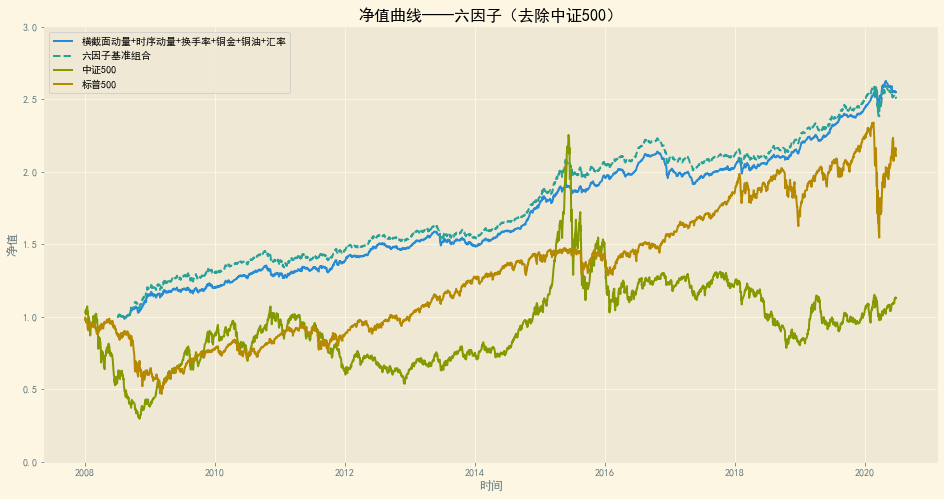

In [69]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_B.index, tradeDF_B['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜金+铜油+汇率')
    
plt.plot(tradeDF_multi2.index, tradeDF_multi2['投资组合净值']/10000, ls='--', label='六因子基准组合') 
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['标普500'], label='标普500')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线——六因子（去除中证500）')
plt.savefig('Pics/净值曲线——六因子（去除中证500）.png')

## 横截面动量+时序动量+换手率+铜金+铜油+汇率（去除信用债3-5AAA）

In [70]:
leverReturns_C    = leverReturns.drop('信用债3-5AAA', axis=1)
leverCumReturns_C = leverCumReturns.drop('信用债3-5AAA', axis=1)

### 程序运行

In [71]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 'fxRate':True,
            'copperGold':True, 'copperGas':True}

tradeDF_C, weightDF_C = AlgoLoop.AlgoTrade(Assets, leverReturns_C, leverCumReturns_C, Turnovers, FXRates, 
                                           mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

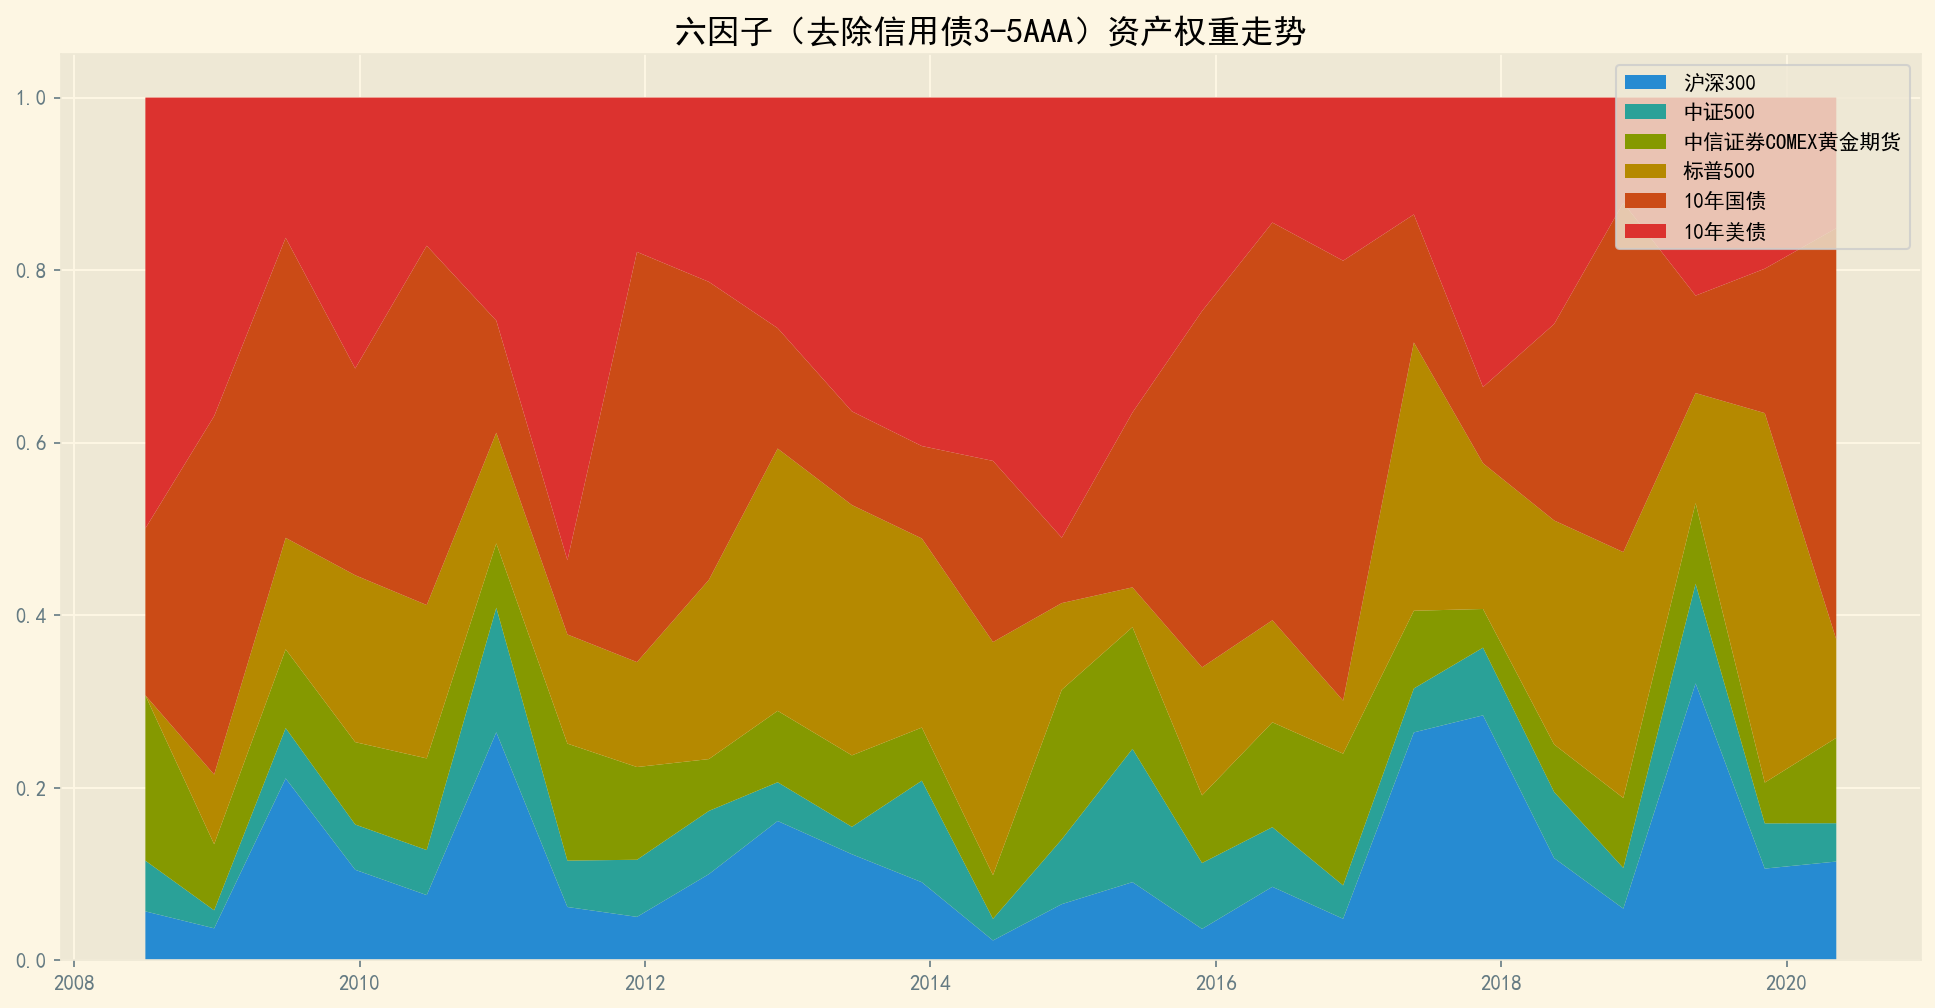

In [72]:
StatisticFunc.WeightPlot(tradeDF_C, weightDF_C, '六因子（去除信用债3-5AAA）')

### 回测表现汇总

In [73]:
smryDF_C = StatisticFunc.summaryDF(tradeDF_C)
pfmcDF_C = StatisticFunc.performanceDF(smryDF_C, tradeDF_C)

In [74]:
smryDF_C

年收益率      年波动率        信息比      最大回撤
2008    0.149267  0.104982    1.42183 -0.062372
2009   0.0395395  0.094639   0.417794 -0.079623
2010   0.0351253  0.066129   0.531166 -0.062000
2011   0.0232956  0.073425   0.317272 -0.081028
2012   0.0482577  0.047957    1.00626 -0.034094
2013  0.00414133  0.065056  0.0636577 -0.074023
2014    0.125008  0.042042    2.97339 -0.057493
2015   0.0868356  0.086398    1.00506 -0.106012
2016  0.00986657  0.054246   0.181885 -0.088178
2017   0.0370165  0.047307   0.782481 -0.097777
2018  -0.0448658  0.065832  -0.681521 -0.096888
2019     0.17234  0.059832    2.88041 -0.071981
2020  -0.0151705  0.186425 -0.0813757 -0.153752

In [75]:
pfmcDF_C

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.051589  0.076482 -0.153752     344.0  0.674522  0.335534

### 收益率贡献度

In [76]:
annualContrb_C = StatisticFunc.AnnualContribution(tradeDF=tradeDF_multi, 
                                                      weightDF=weightDF_multi, 
                                                      assetDF=leverCumReturns_C)

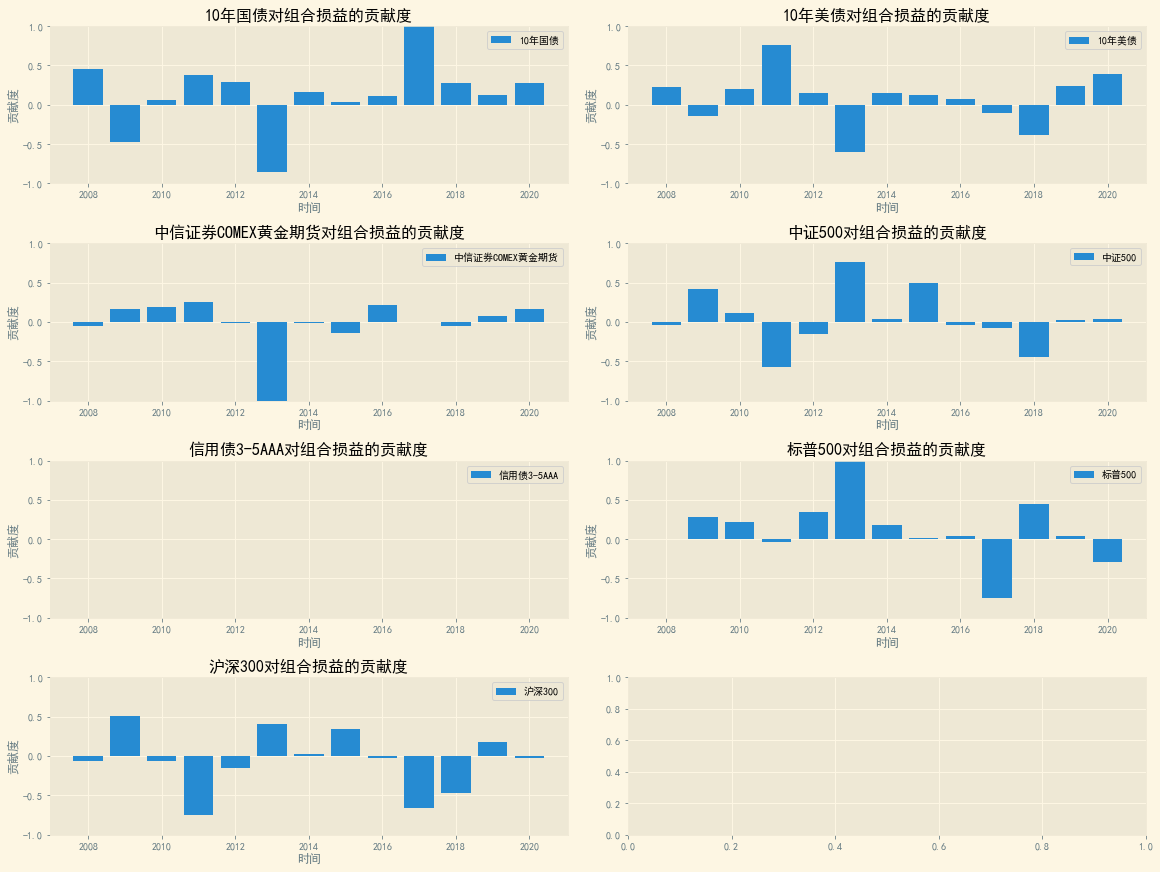

In [77]:
StatisticFunc.BarPlot(annualContrb_C, '六因子（去除信用债3-5AAA）')

### 投资组合净值曲线

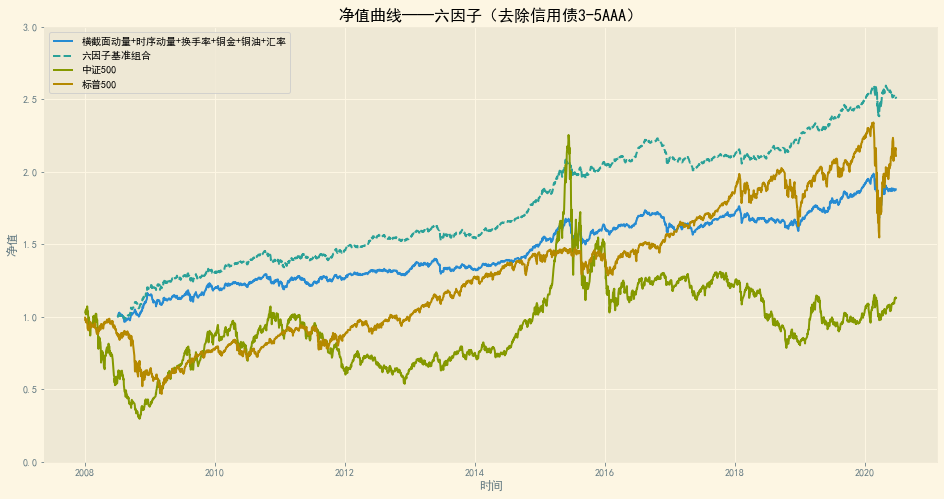

In [78]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_C.index, tradeDF_C['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜金+铜油+汇率')
    
plt.plot(tradeDF_multi2.index, tradeDF_multi2['投资组合净值']/10000, ls='--', label='六因子基准组合') 
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['标普500'], label='标普500')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线——六因子（去除信用债3-5AAA）')
plt.savefig('Pics/净值曲线——六因子（去除信用债3-5AAA）.png')

## 横截面动量+时序动量+换手率+铜金+铜油+汇率（去除COMEX黄金期货）

In [79]:
leverReturns_D    = leverReturns.drop('中信证券COMEX黄金期货', axis=1)
leverCumReturns_D = leverCumReturns.drop('中信证券COMEX黄金期货', axis=1)

### 程序运行

In [80]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 'fxRate':True,
            'copperGold':True, 'copperGas':True}

tradeDF_D, weightDF_D = AlgoLoop.AlgoTrade(Assets, leverReturns_D, leverCumReturns_D, Turnovers, FXRates, 
                                           mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

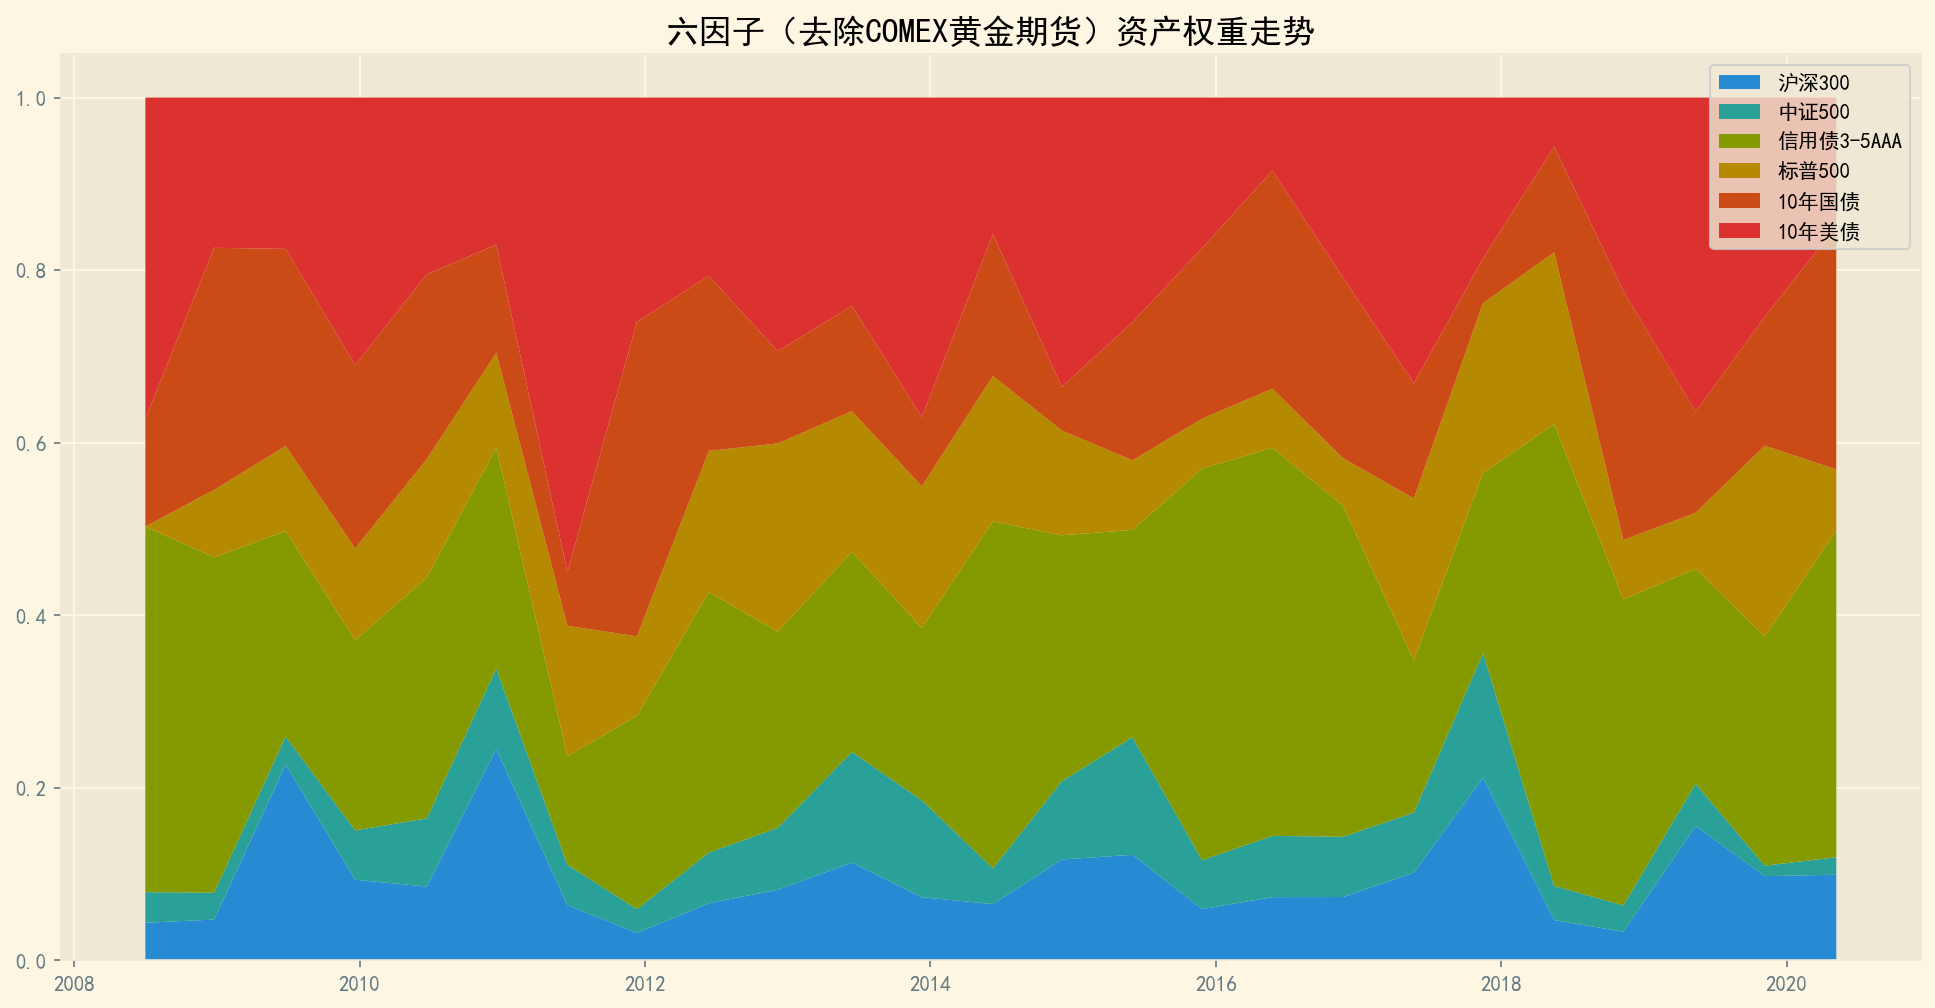

In [81]:
StatisticFunc.WeightPlot(tradeDF_D, weightDF_D, '六因子（去除COMEX黄金期货）')

### 回测表现汇总

In [82]:
smryDF_D = StatisticFunc.summaryDF(tradeDF_D)
pfmcDF_D = StatisticFunc.performanceDF(smryDF_D, tradeDF_D)

In [83]:
smryDF_D

年收益率      年波动率        信息比      最大回撤
2008    0.223789  0.099124    2.25767 -0.033087
2009   0.0759556  0.090758   0.836905 -0.065730
2010   0.0616068  0.059805    1.03013 -0.063168
2011   0.0450336  0.066178   0.680491 -0.074805
2012   0.0596748  0.036020     1.6567 -0.033462
2013    0.016183  0.059679   0.271168 -0.071108
2014    0.219137  0.043173    5.07584 -0.065359
2015    0.191333  0.090302    2.11882 -0.094335
2016  0.00636585  0.043061   0.147835 -0.073743
2017  0.00309882  0.033511  0.0924713 -0.090754
2018     0.07798  0.052180    1.49444 -0.080096
2019    0.120334  0.031590    3.80926 -0.025133
2020   0.0170535  0.092210   0.184942 -0.071112

In [84]:
pfmcDF_D

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.085965  0.061353 -0.094335     438.0  1.401153  0.911278

### 收益率贡献度

In [85]:
annualContrb_D = StatisticFunc.AnnualContribution(tradeDF=tradeDF_multi, 
                                                      weightDF=weightDF_multi, 
                                                      assetDF=leverCumReturns_D)

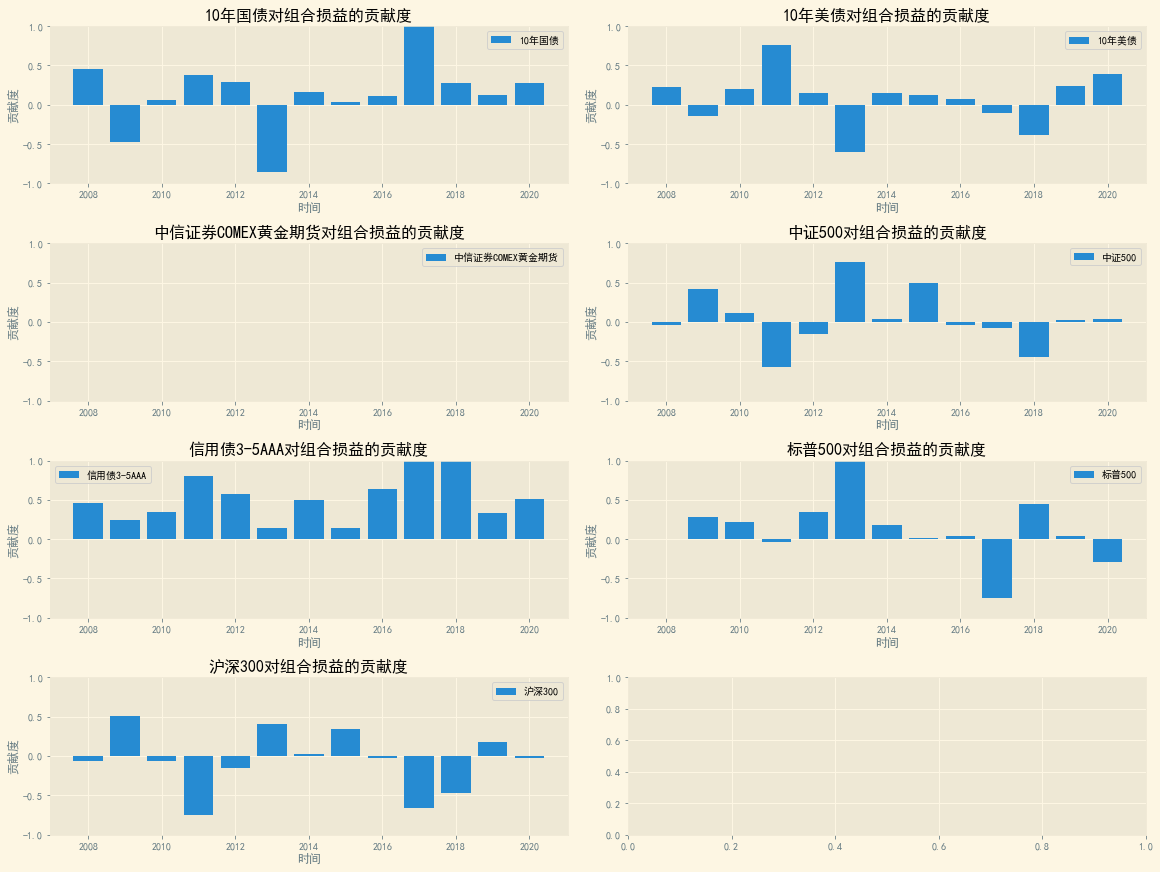

In [86]:
StatisticFunc.BarPlot(annualContrb_D, '六因子（去除COMEX黄金期货）')

### 投资组合净值曲线

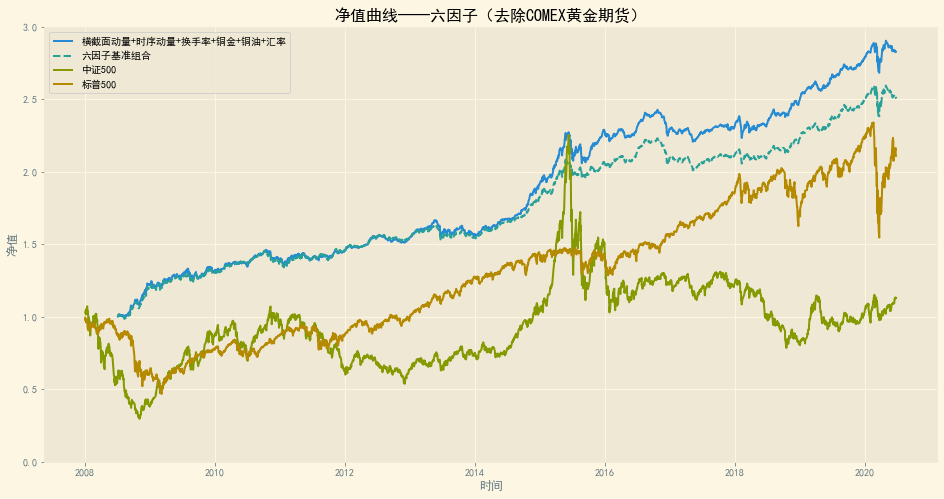

In [87]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_D.index, tradeDF_D['投资组合净值']/10000, label='横截面动量+时序动量+换手率+铜金+铜油+汇率')
    
plt.plot(tradeDF_multi2.index, tradeDF_multi2['投资组合净值']/10000, ls='--', label='六因子基准组合') 
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['标普500'], label='标普500')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线——六因子（去除COMEX黄金期货）')
plt.savefig('Pics/净值曲线——六因子（去除COMEX黄金期货）.png')

# 风险平价 + 杠杆 + 单因子策略（指数平均）

## 换手率

### 程序运行

In [88]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 'fxRate':False,
            'copperGold':False, 'copperGas':False}

tradeDF_1, weightDF_1 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, FXRates, 
                                           mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

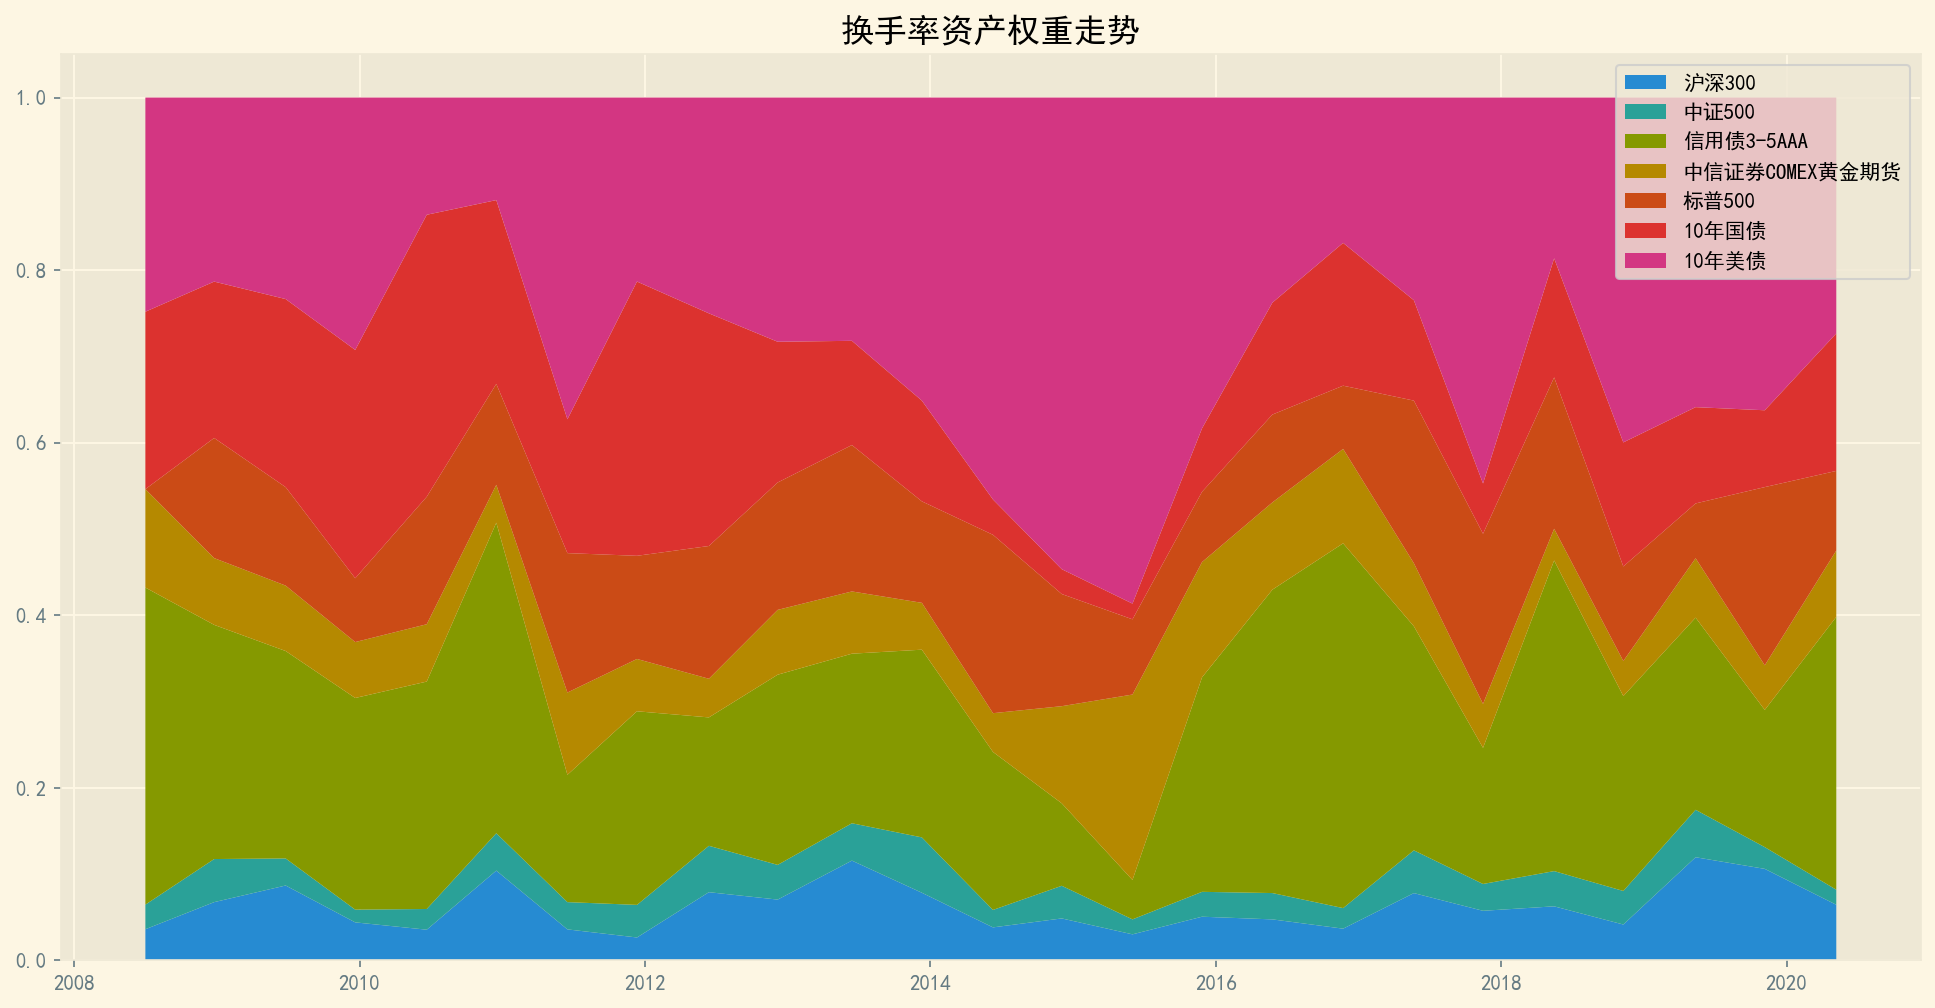

In [89]:
StatisticFunc.WeightPlot(tradeDF_1, weightDF_1, '换手率')

### 回测表现汇总

In [90]:
smryDF_1 = StatisticFunc.summaryDF(tradeDF_1)
pfmcDF_1 = StatisticFunc.performanceDF(smryDF_1, tradeDF_1)

In [91]:
smryDF_1

年收益率      年波动率       信息比      最大回撤
2008   0.234684  0.100691   2.33075 -0.039331
2009   0.108829  0.075488   1.44168 -0.042147
2010  0.0772364  0.050587   1.52681 -0.062278
2011  0.0760491  0.061681   1.23295 -0.070389
2012  0.0571652  0.036397   1.57059 -0.028831
2013 -0.0237302  0.051575 -0.460115 -0.071392
2014   0.159507  0.031097   5.12935 -0.074774
2015   0.079672  0.051058   1.56041 -0.032759
2016  0.0267778  0.039261  0.682037 -0.074557
2017  0.0176629  0.026457  0.667607 -0.081405
2018  0.0405657  0.036487   1.11177 -0.058358
2019   0.131889  0.031006   4.25362 -0.016363
2020  0.0227446  0.091964  0.247319 -0.071514

In [92]:
pfmcDF_1

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.077619  0.052596 -0.081405     559.0  1.475764  0.953495

### 收益率贡献度

In [93]:
annualContrb_1 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_1, weightDF=weightDF_1, assetDF=leverCumReturns)

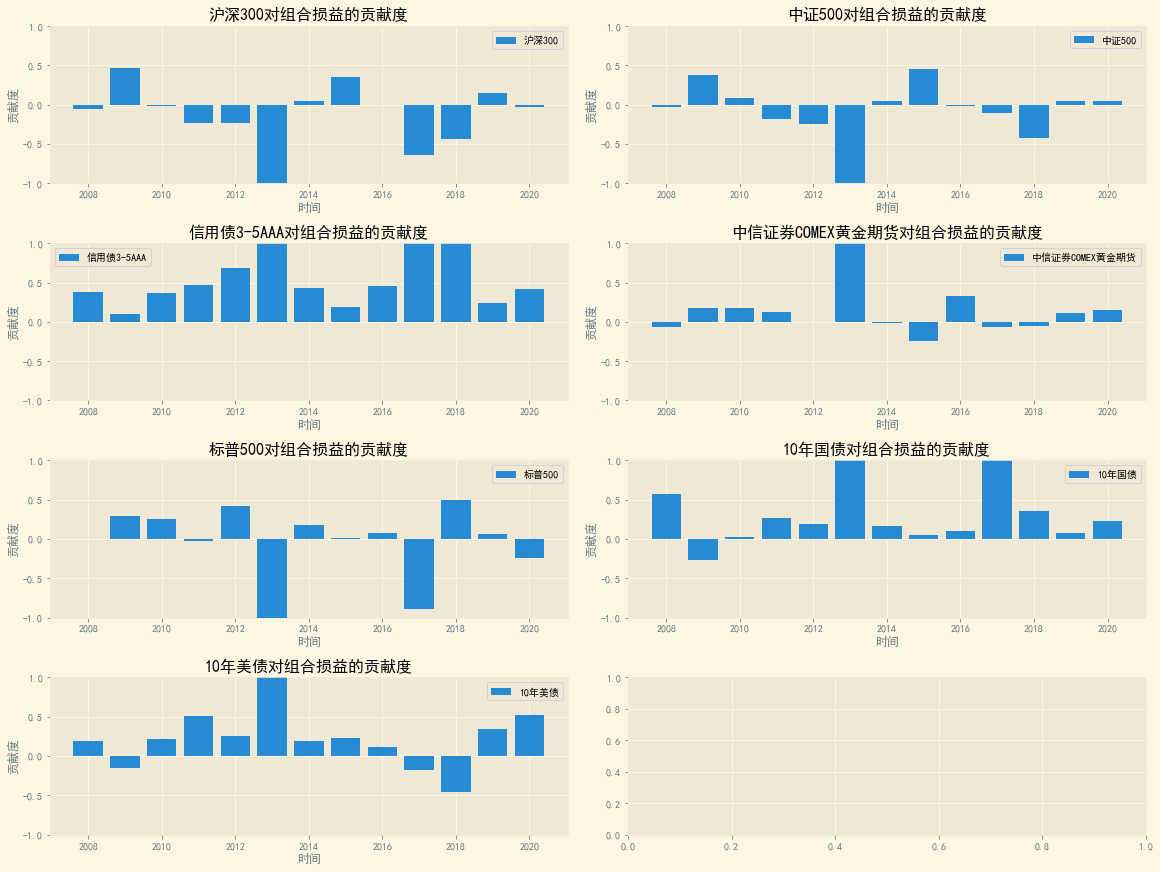

In [94]:
StatisticFunc.BarPlot(annualContrb_1, '换手率')

### 投资组合净值曲线

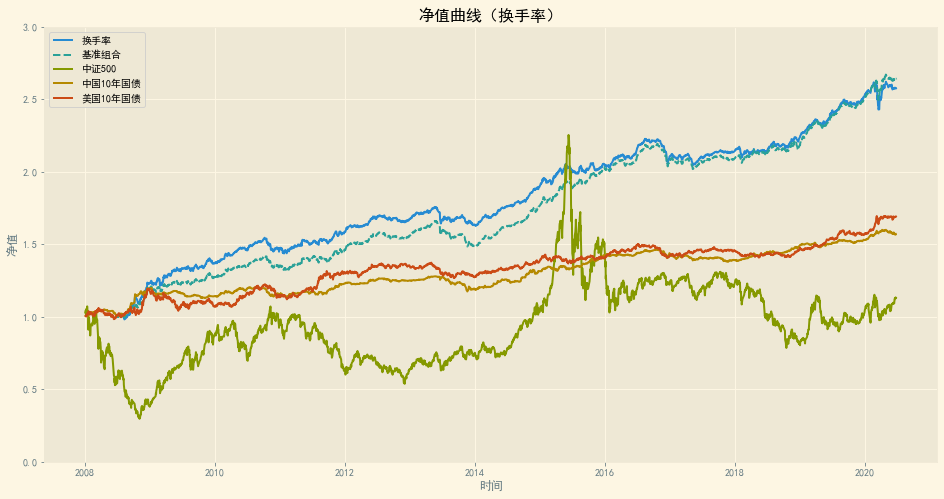

In [95]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_1.index, tradeDF_1['投资组合净值']/10000, label='换手率')

# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='基准组合')     
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='中国10年国债')
plt.plot(cumReturns.index, cumReturns['10年美债'], label='美国10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线（换手率）')
plt.savefig('Pics/净值曲线（换手率）.png')

## 横截面动量

### 程序运行

In [96]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 'fxRate':False,
            'copperGold':False, 'copperGas':False}

tradeDF_2, weightDF_2 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, FXRates, 
                                           mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

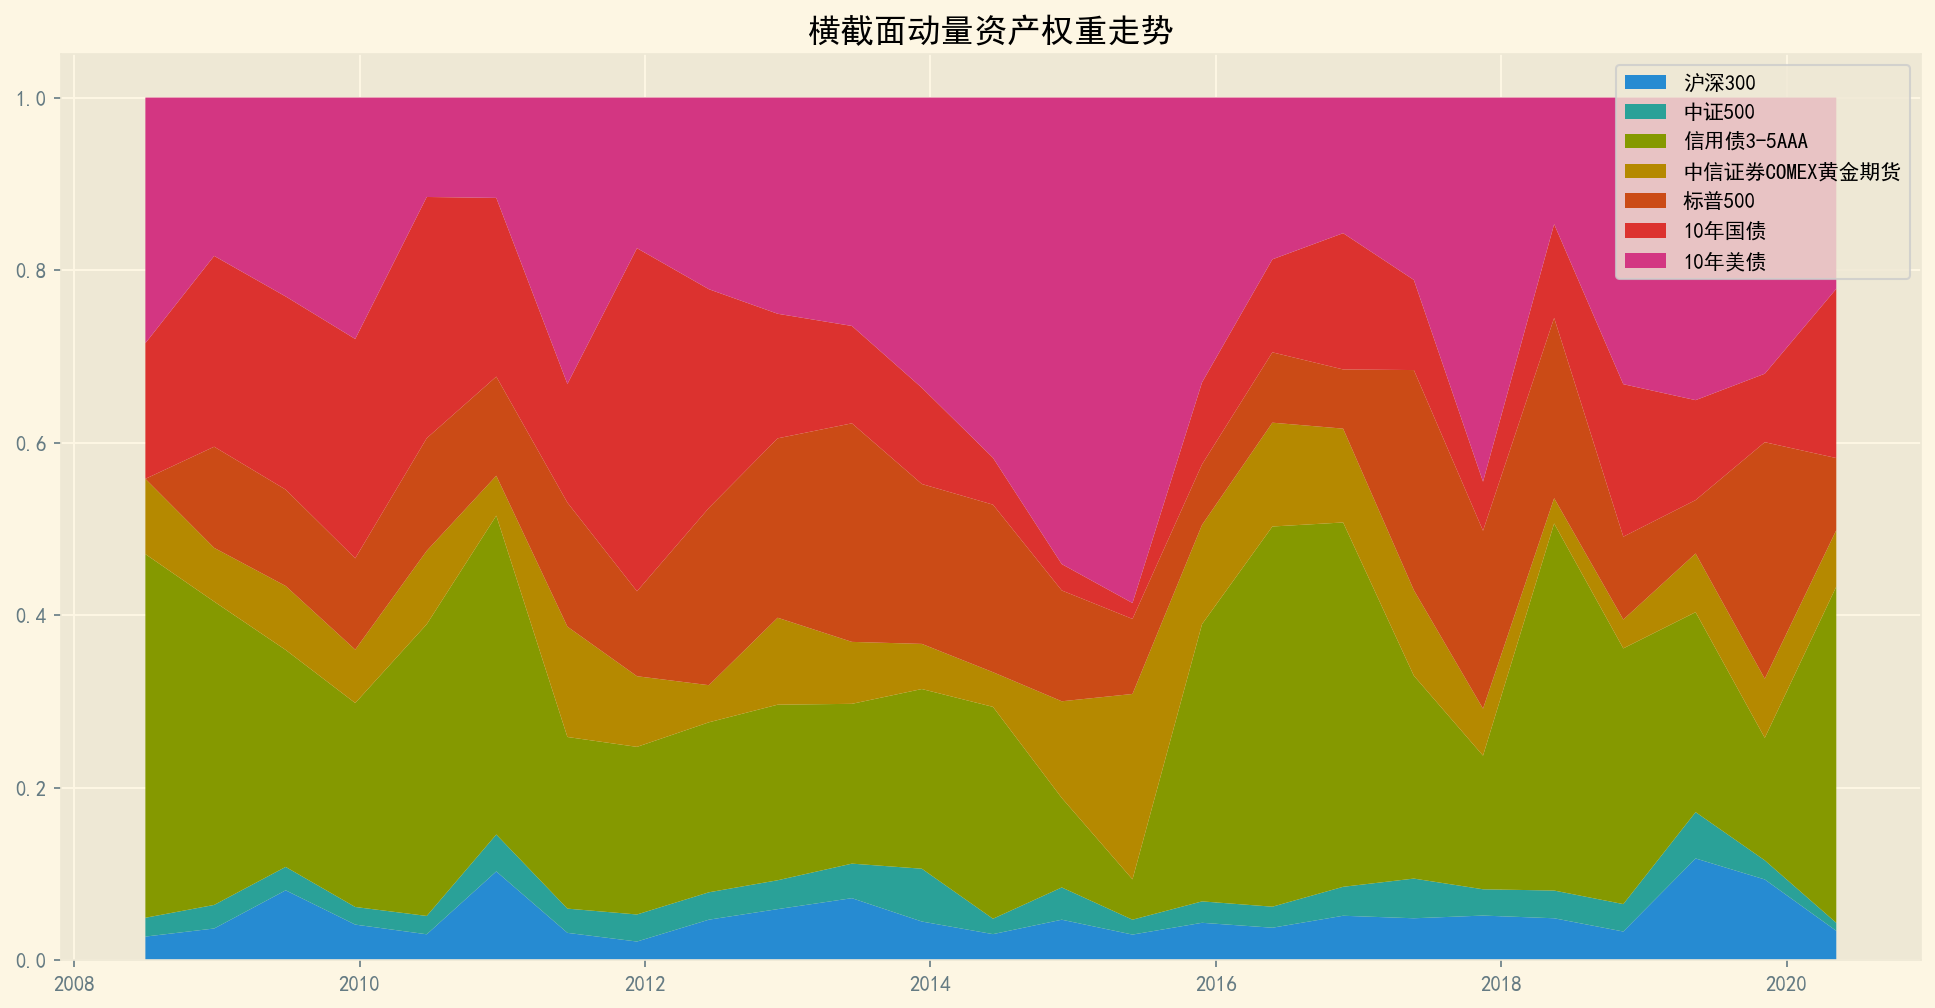

In [97]:
StatisticFunc.WeightPlot(tradeDF_2, weightDF_2, '横截面动量')

### 回测表现汇总

In [98]:
smryDF_2 = StatisticFunc.summaryDF(tradeDF_2)
pfmcDF_2 = StatisticFunc.performanceDF(smryDF_2, tradeDF_2)

In [99]:
smryDF_2

年收益率      年波动率        信息比      最大回撤
2008    0.232388  0.098573    2.35753 -0.037310
2009   0.0700929  0.070097    0.99994 -0.035666
2010   0.0736403  0.050543      1.457 -0.062599
2011   0.0782027  0.063180    1.23778 -0.070727
2012   0.0627809  0.037286    1.68375 -0.026064
2013 -0.00570105  0.050892  -0.112023 -0.060916
2014    0.166357  0.029601    5.62001 -0.058496
2015   0.0834383  0.050609    1.64869 -0.032585
2016   0.0267396  0.038114    0.70156 -0.075118
2017    0.016204  0.027163   0.596555 -0.082584
2018   0.0547461  0.037321    1.46689 -0.061183
2019     0.12968  0.030187    4.29585 -0.017212
2020  0.00278838  0.117980  0.0236344 -0.094548

In [100]:
pfmcDF_2

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.076258  0.053965 -0.094548     502.0  1.413105  0.806559

### 收益率贡献度

In [101]:
annualContrb_2 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_2, weightDF=weightDF_2, assetDF=leverCumReturns)

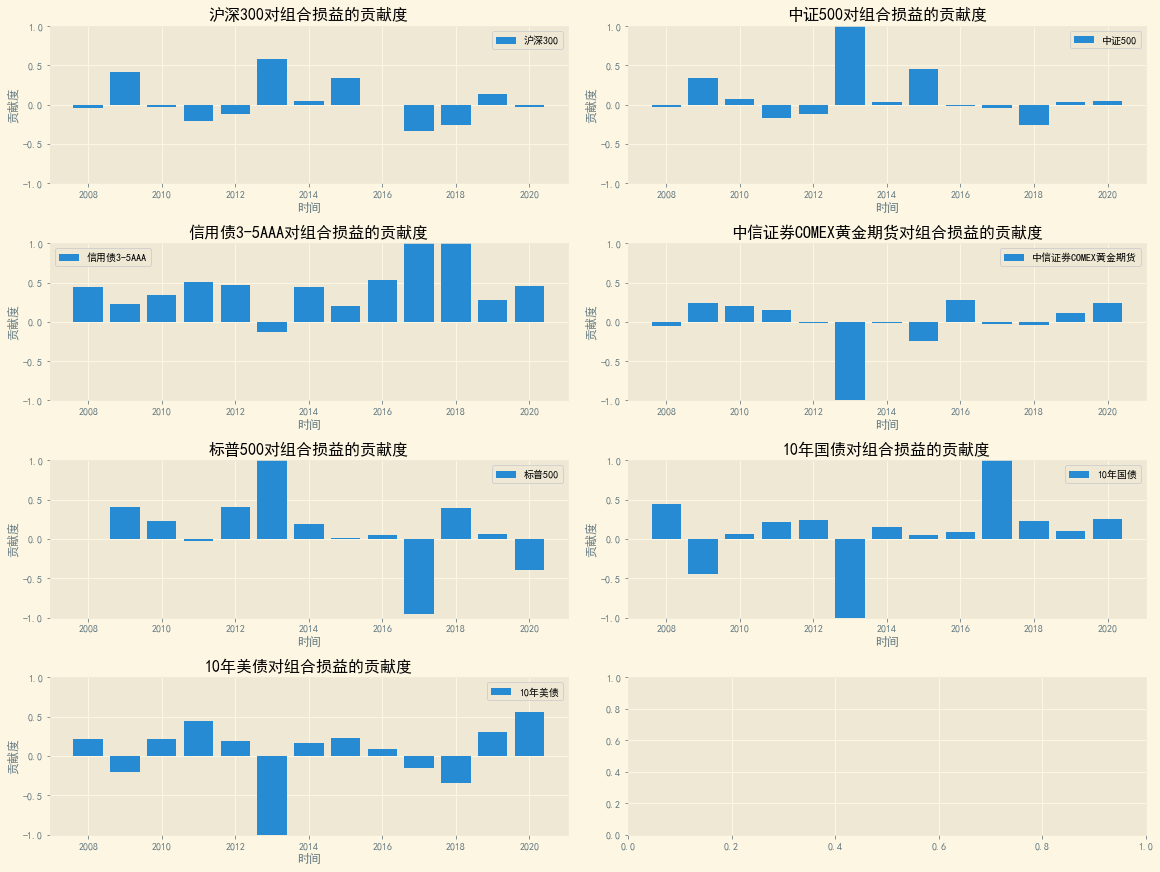

In [102]:
StatisticFunc.BarPlot(annualContrb_2, '横截面动量')

### 投资组合净值曲线

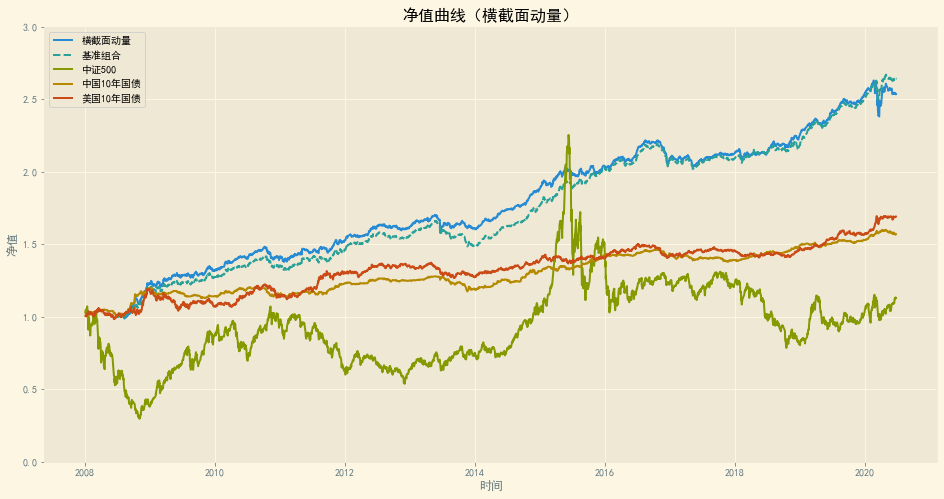

In [103]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_2.index, tradeDF_2['投资组合净值']/10000, label='横截面动量')
        
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='基准组合')  
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='中国10年国债')
plt.plot(cumReturns.index, cumReturns['10年美债'], label='美国10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线（横截面动量）')
plt.savefig('Pics/净值曲线（横截面动量）.png')

## 时序动量

### 程序运行

In [104]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':True, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 'fxRate':False,
            'copperGold':False, 'copperGas':False}

tradeDF_3, weightDF_3 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, FXRates, 
                                           mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

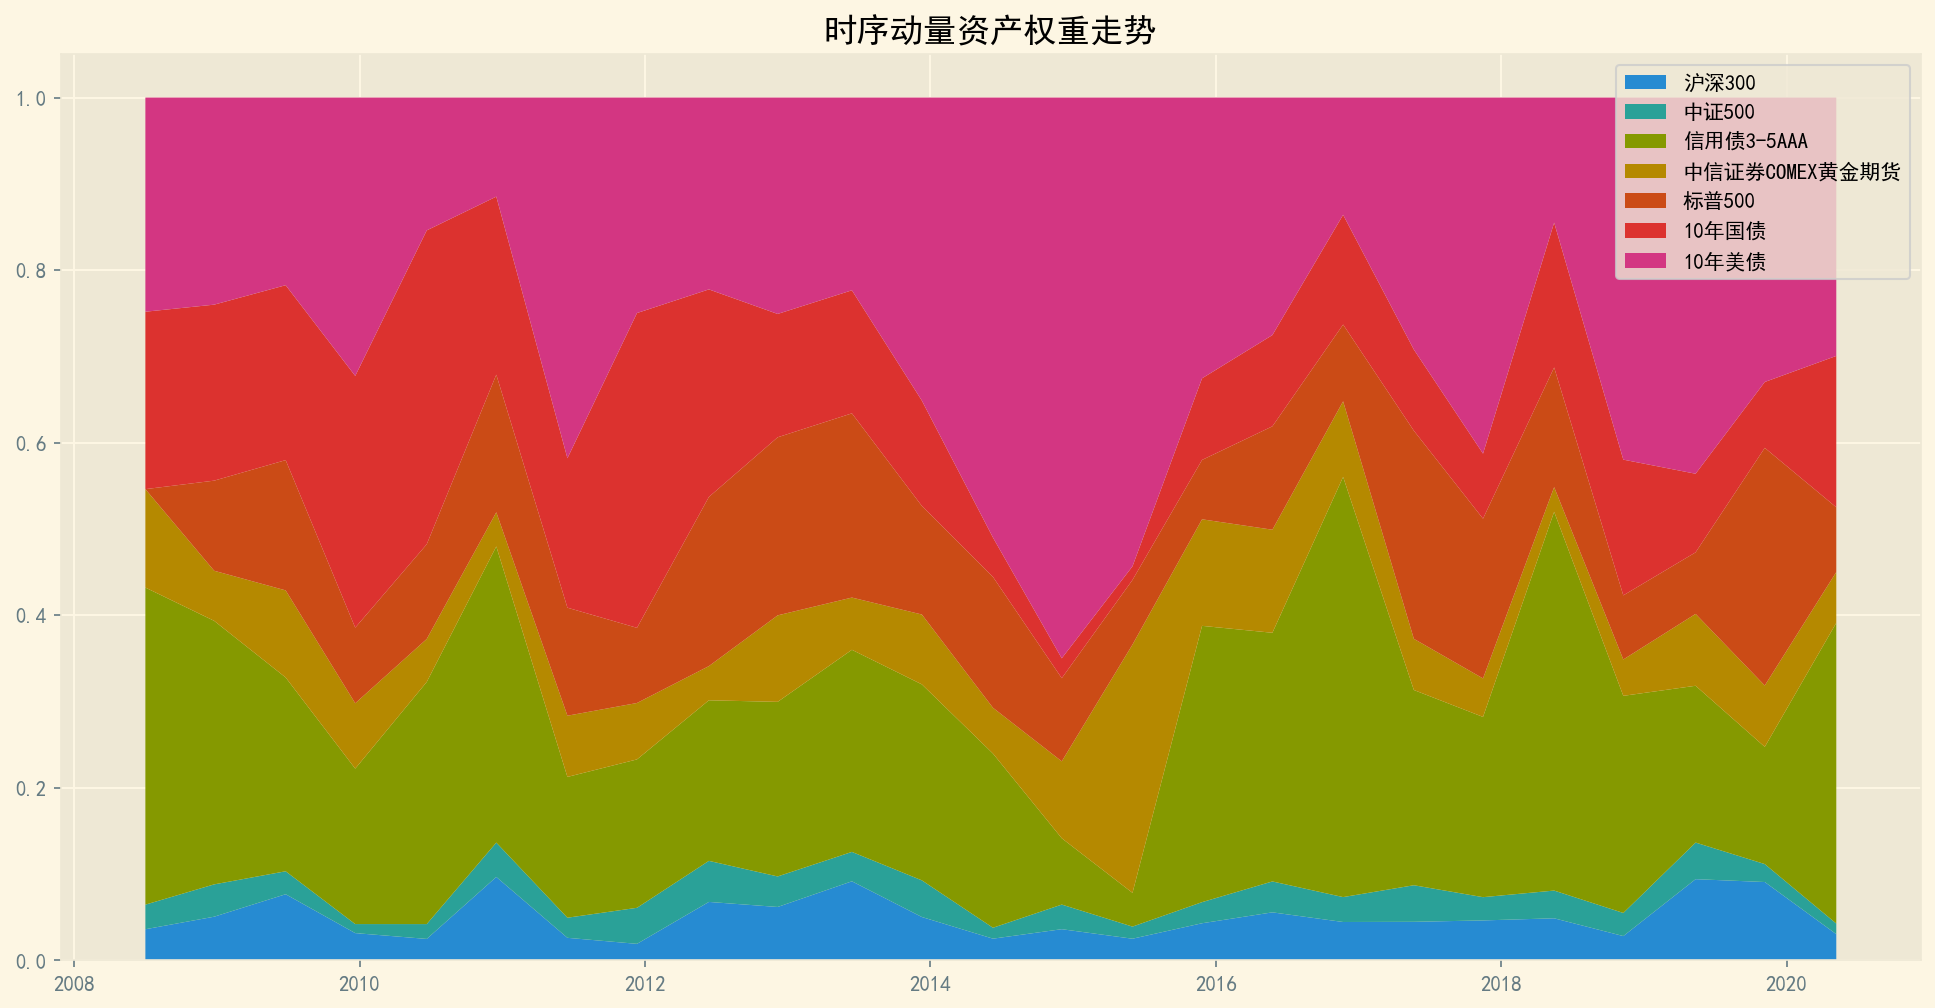

In [105]:
StatisticFunc.WeightPlot(tradeDF_3, weightDF_3, '时序动量')

### 回测表现汇总

In [106]:
smryDF_3 = StatisticFunc.summaryDF(tradeDF_3)
pfmcDF_3 = StatisticFunc.performanceDF(smryDF_3, tradeDF_3)

In [107]:
smryDF_3

年收益率      年波动率        信息比      最大回撤
2008    0.233301  0.100733    2.31602 -0.039331
2009    0.093806  0.071360    1.31455 -0.034361
2010   0.0639738  0.049948    1.28082 -0.071163
2011   0.0836004  0.058112    1.43862 -0.077045
2012   0.0535841  0.037229    1.43931 -0.028328
2013  -0.0218054  0.051399  -0.424243 -0.070191
2014    0.158667  0.029023    5.46686 -0.072250
2015   0.0620238  0.052638     1.1783 -0.037538
2016   0.0216256  0.038824   0.557013 -0.074930
2017    0.013218  0.025233   0.523842 -0.083690
2018   0.0688289  0.032463    2.12025 -0.062702
2019    0.125298  0.028993    4.32158 -0.016795
2020  0.00495569  0.117753  0.0420855 -0.094306

In [108]:
pfmcDF_3

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.073929  0.053362 -0.094306     538.0  1.385421  0.783929

### 收益率贡献度

In [109]:
annualContrb_3 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_3, weightDF=weightDF_3, assetDF=leverCumReturns)

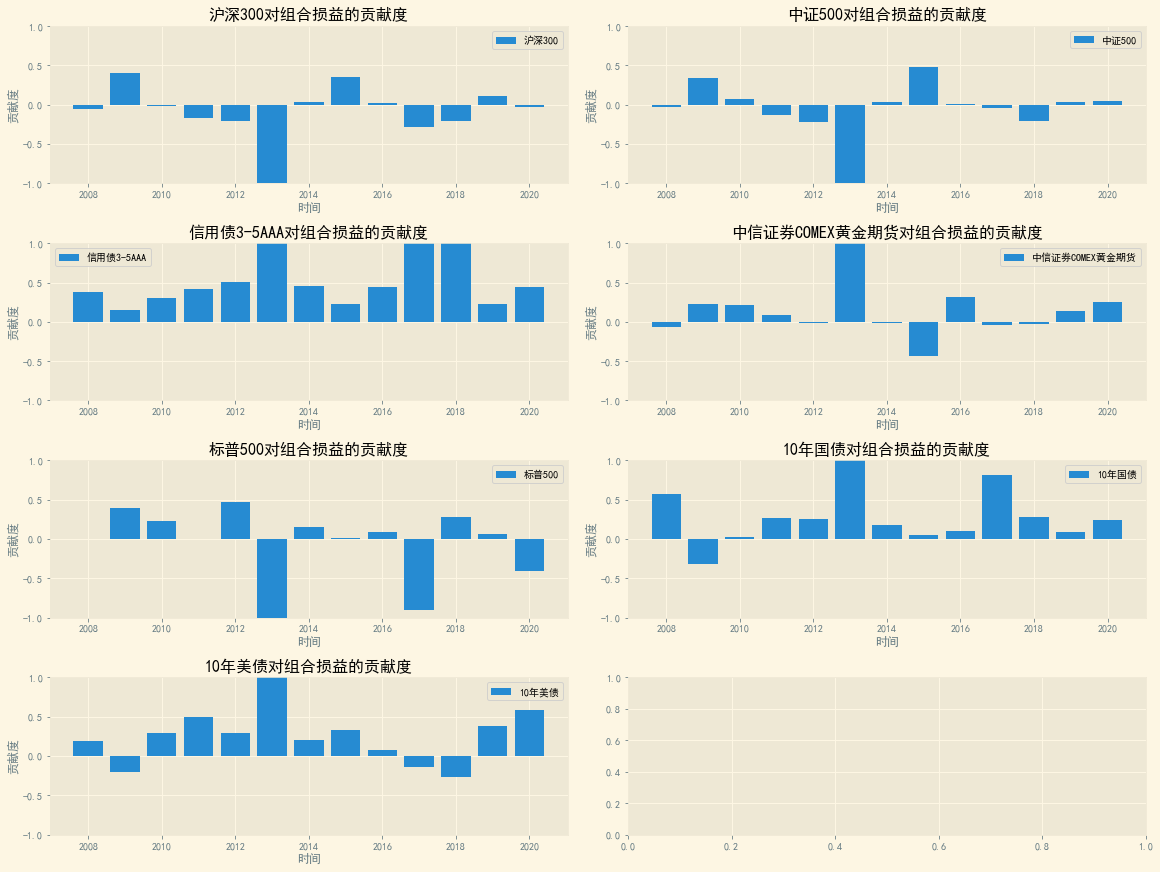

In [110]:
StatisticFunc.BarPlot(annualContrb_3, '时序动量')

### 投资组合净值曲线

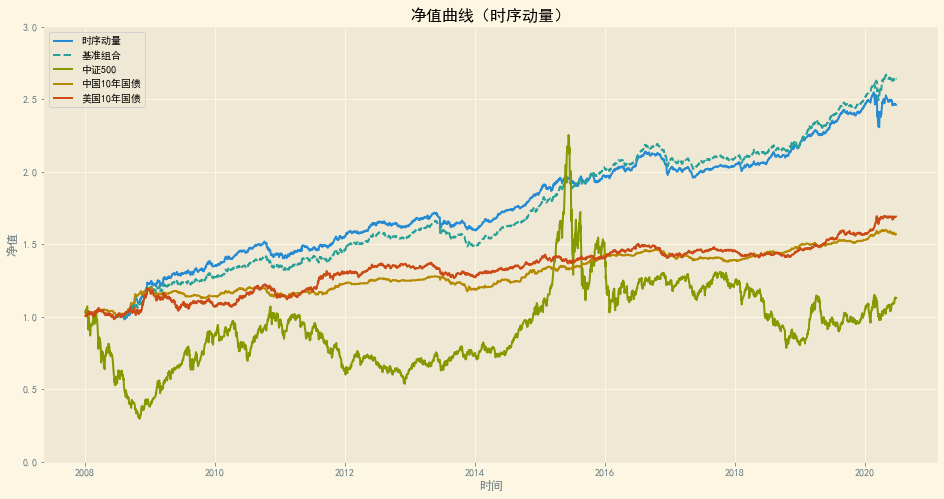

In [111]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_3.index, tradeDF_3['投资组合净值']/10000, label='时序动量')
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='基准组合') 
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='中国10年国债')
plt.plot(cumReturns.index, cumReturns['10年美债'], label='美国10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线（时序动量）')
plt.savefig('Pics/净值曲线（时序动量）D.png')

## 汇率因子

### 程序运行

In [112]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 'fxRate':True,
            'copperGold':True, 'copperGas':False}

tradeDF_4, weightDF_4 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, FXRates, 
                                           mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

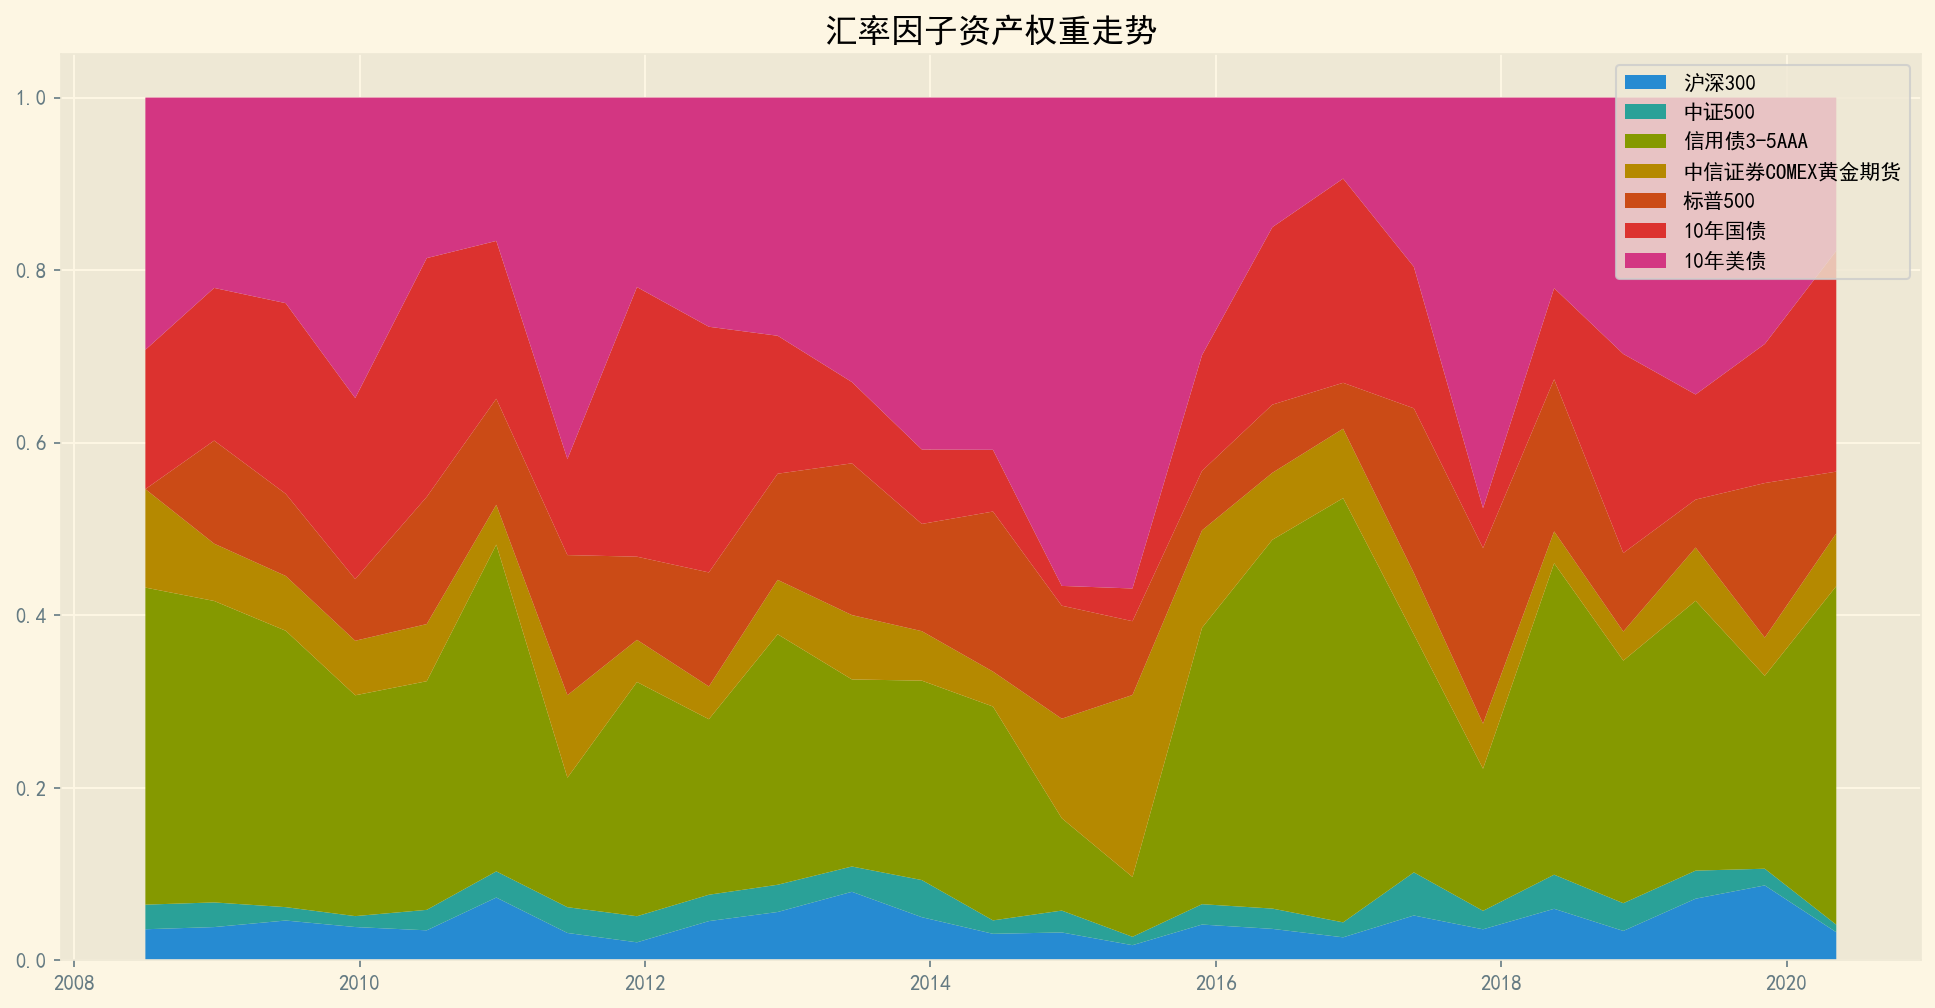

In [113]:
StatisticFunc.WeightPlot(tradeDF_4, weightDF_4, '汇率因子')

### 回测表现汇总

In [114]:
smryDF_4 = StatisticFunc.summaryDF(tradeDF_4)
pfmcDF_4 = StatisticFunc.performanceDF(smryDF_4, tradeDF_4)

In [115]:
smryDF_4

年收益率      年波动率       信息比      最大回撤
2008    0.216254  0.096870   2.23241 -0.040233
2009   0.0581146  0.065930  0.881465 -0.032735
2010   0.0843795  0.048221   1.74985 -0.058412
2011   0.0834015  0.060121   1.38723 -0.064380
2012   0.0650343  0.032930   1.97493 -0.025443
2013   -0.018126  0.045758 -0.396126 -0.066559
2014     0.16428  0.028295   5.80602 -0.068883
2015   0.0787129  0.047040    1.6733 -0.026007
2016   0.0242402  0.039293  0.616905 -0.084020
2017 -0.00545697  0.027409 -0.199098 -0.100264
2018   0.0446523  0.035782    1.2479 -0.084164
2019    0.125232  0.026672   4.69531 -0.020314
2020   0.0244691  0.080819  0.302762 -0.060014

In [116]:
pfmcDF_4

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.072707  0.048857 -0.100264     557.0  1.488156  0.725151

### 收益率贡献度

In [117]:
annualContrb_4 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_4, weightDF=weightDF_4, assetDF=leverCumReturns)

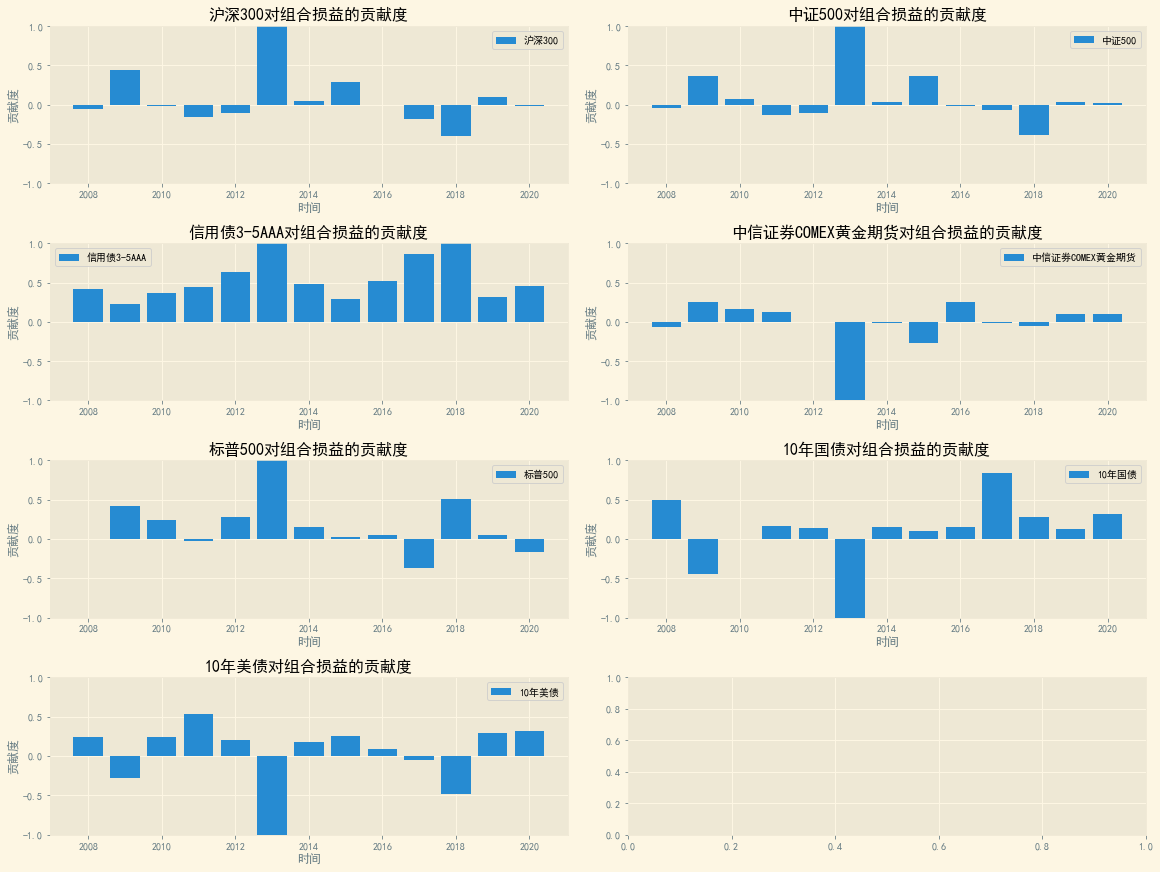

In [118]:
StatisticFunc.BarPlot(annualContrb_4, '汇率因子')

### 投资组合净值曲线

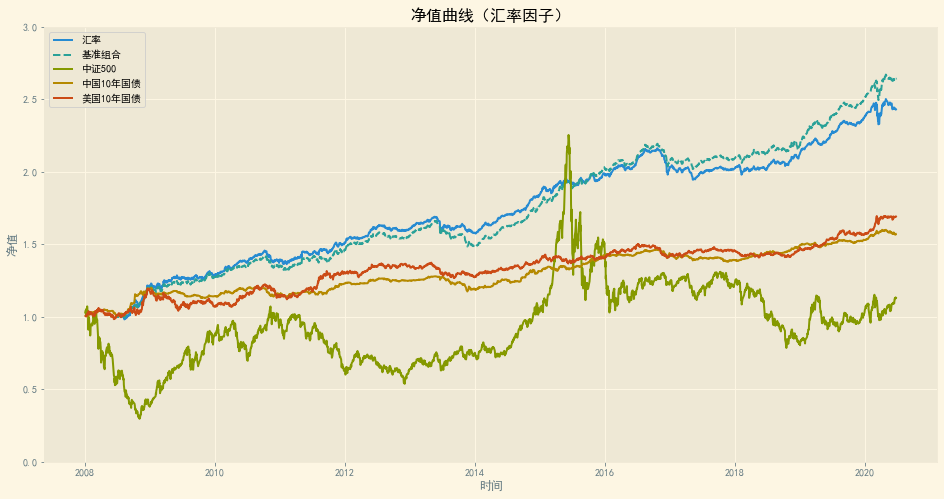

In [119]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_4.index, tradeDF_4['投资组合净值']/10000, label='汇率')
    
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='基准组合') 
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='中国10年国债')
plt.plot(cumReturns.index, cumReturns['10年美债'], label='美国10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线（汇率因子）')
plt.savefig('Pics/净值曲线（汇率因子）.png')

## 铜金

### 程序运行

In [120]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 'fxRate':False,
            'copperGold':True, 'copperGas':False}

tradeDF_5, weightDF_5 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, FXRates, 
                                           mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

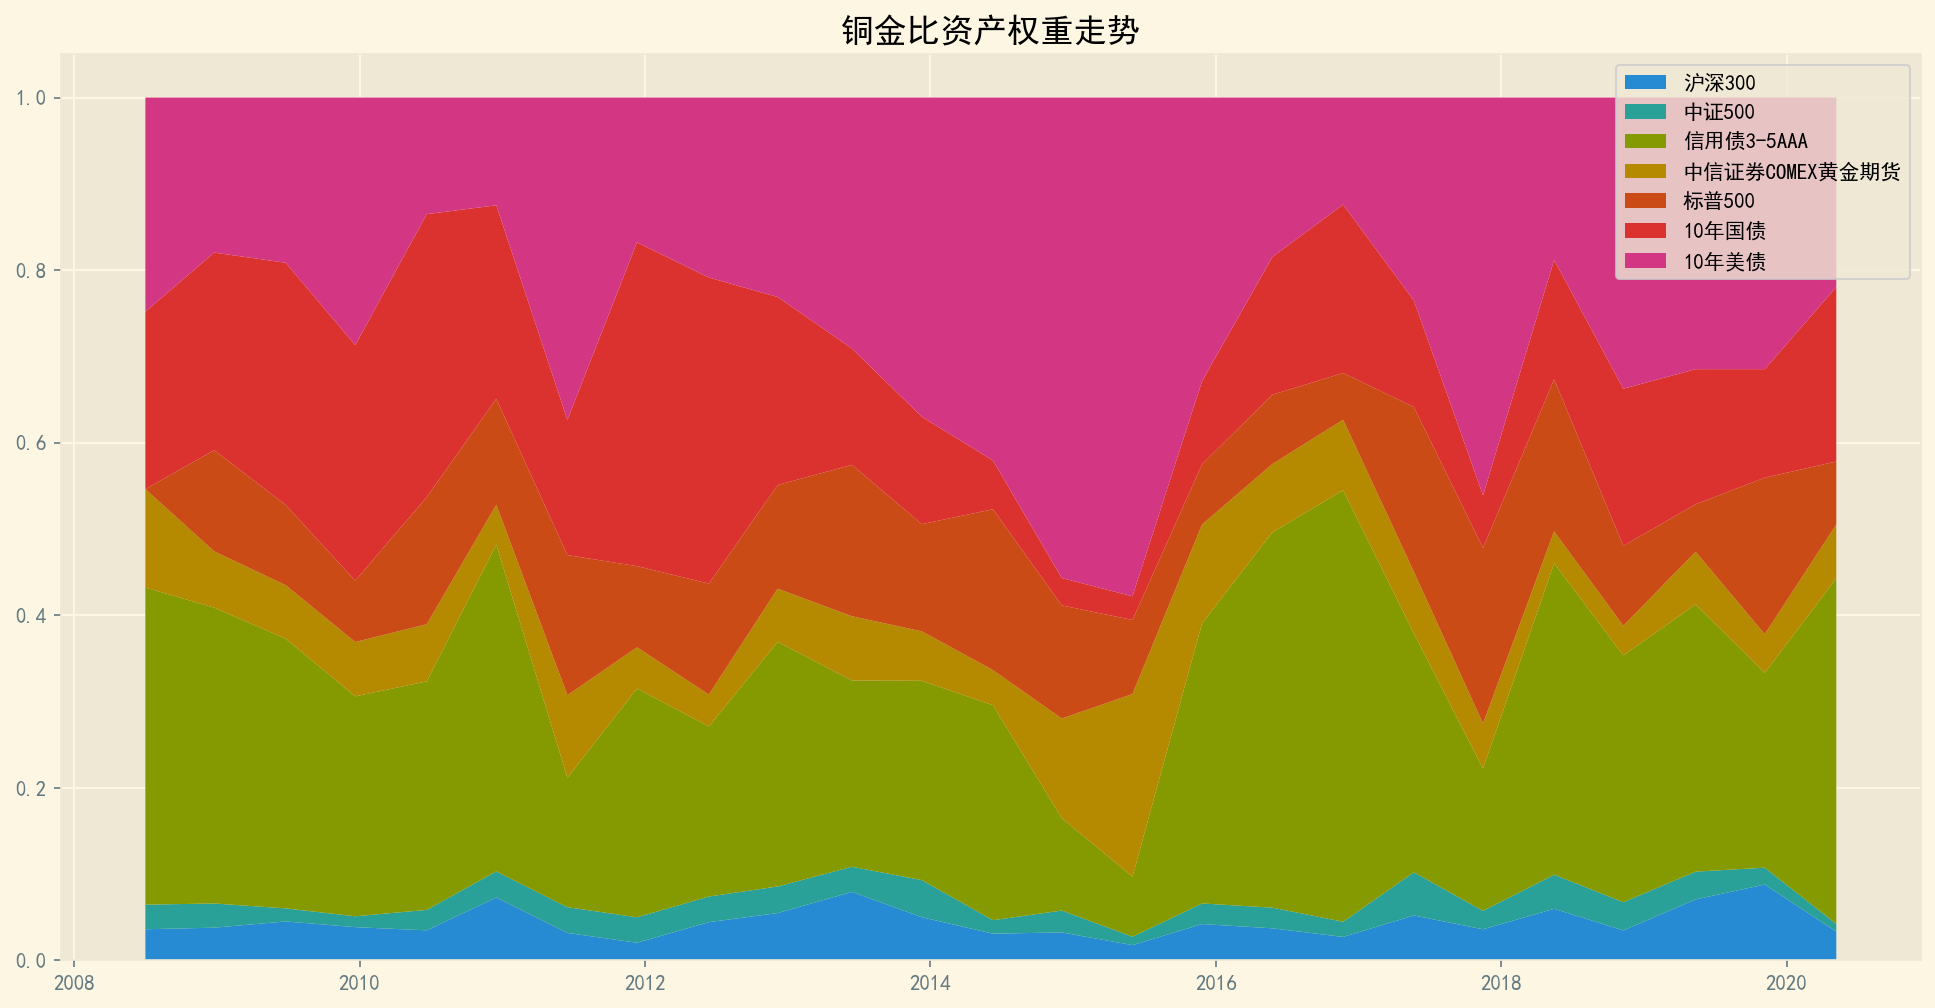

In [121]:
StatisticFunc.WeightPlot(tradeDF_5, weightDF_5, '铜金比')

### 回测表现汇总

In [122]:
smryDF_5 = StatisticFunc.summaryDF(tradeDF_5)
pfmcDF_5 = StatisticFunc.performanceDF(smryDF_5, tradeDF_5)

In [123]:
smryDF_5

年收益率      年波动率        信息比      最大回撤
2008   0.235775  0.100874    2.33733 -0.039331
2009  0.0521716  0.066373    0.78604 -0.035778
2010  0.0819349  0.050396    1.62582 -0.061930
2011  0.0851161  0.061025    1.39478 -0.067286
2012   0.062556  0.034708    1.80234 -0.028485
2013 -0.0219481  0.046648  -0.470506 -0.072376
2014   0.166742  0.028540     5.8424 -0.075190
2015  0.0753415  0.047089    1.59999 -0.026017
2016  0.0249477  0.038310    0.65121 -0.080769
2017  0.0019041  0.026189  0.0727068 -0.094833
2018  0.0465055  0.035647    1.30462 -0.076067
2019    0.12516  0.026141    4.78782 -0.017561
2020  0.0244229  0.080942   0.301732 -0.060833

In [124]:
pfmcDF_5

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.073895  0.049452 -0.094833     540.0  1.494257  0.779211

### 收益率贡献度

In [125]:
annualContrb_5 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_5, weightDF=weightDF_5, assetDF=leverCumReturns)

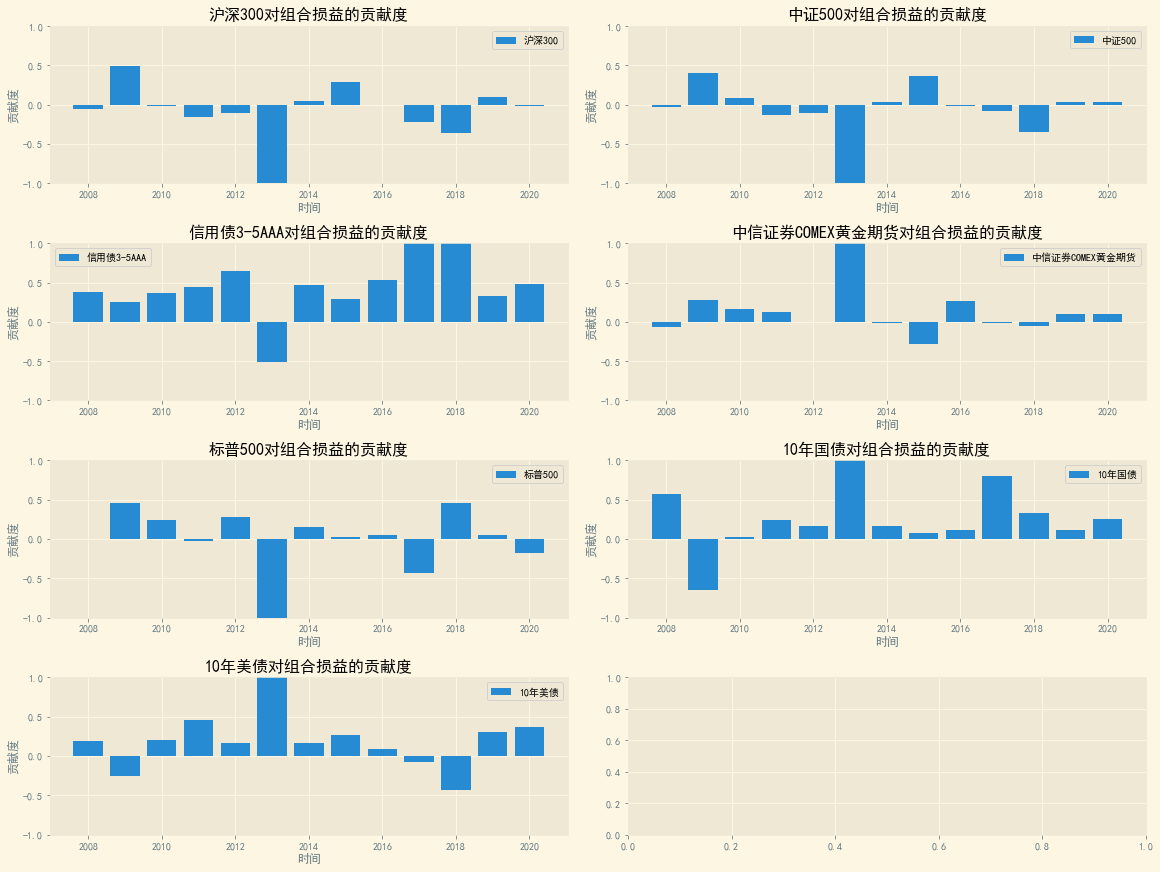

In [126]:
StatisticFunc.BarPlot(annualContrb_5, '铜金比')

### 投资组合净值曲线

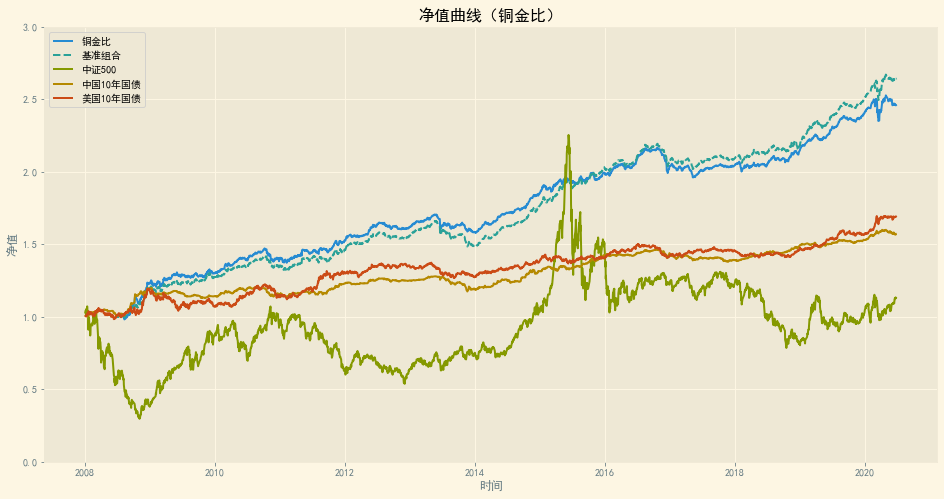

In [127]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_5.index, tradeDF_5['投资组合净值']/10000, label='铜金比')
    
    
# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='基准组合')   
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='中国10年国债')
plt.plot(cumReturns.index, cumReturns['10年美债'], label='美国10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线（铜金比）')
plt.savefig('Pics/净值曲线（铜金比）.png')

## 铜油

### 程序运行

In [128]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':False, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 'fxRate':False,
            'copperGold':False, 'copperGas':True}

tradeDF_6, weightDF_6 = AlgoLoop.AlgoTrade(Assets, leverReturns, leverCumReturns, Turnovers, FXRates, 
                                           mode='ema', dt=120, up=0.50, thresholds=thrds, factorDict=factors)

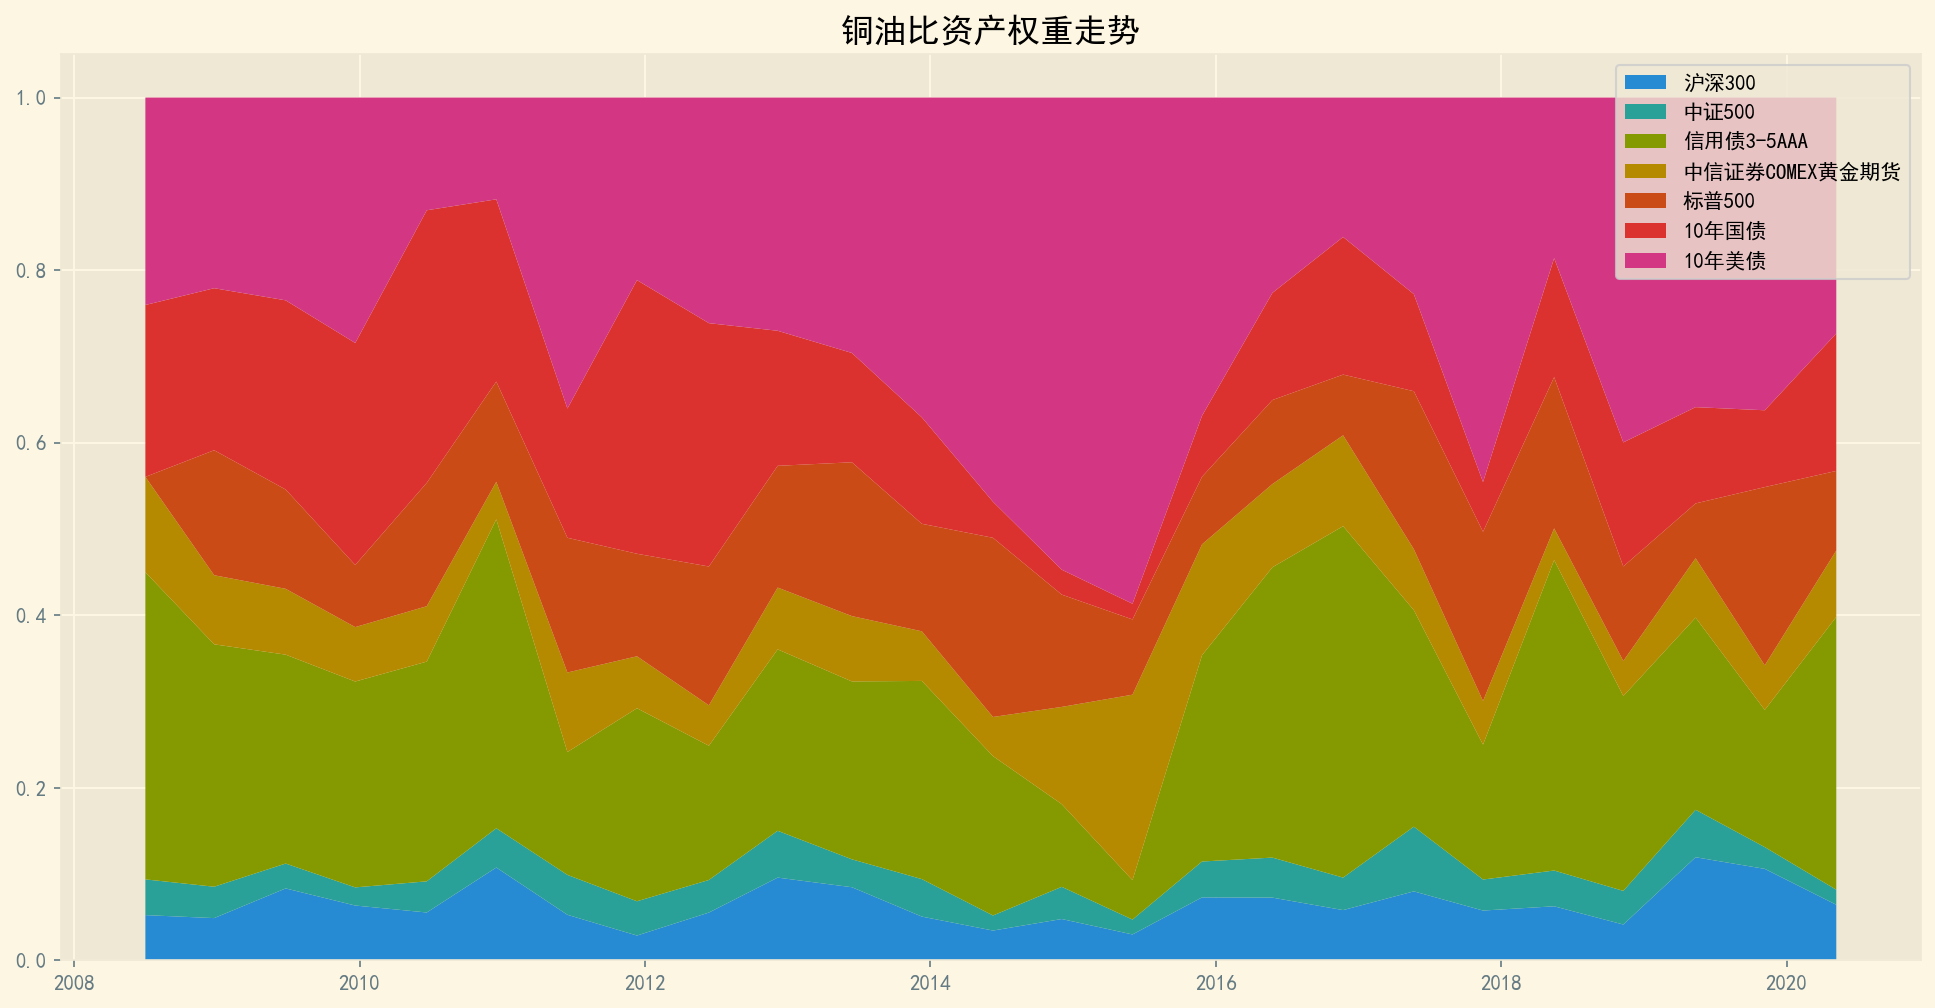

In [129]:
StatisticFunc.WeightPlot(tradeDF_6, weightDF_6, '铜油比')

### 回测表现汇总

In [130]:
smryDF_6 = StatisticFunc.summaryDF(tradeDF_6)
pfmcDF_6 = StatisticFunc.performanceDF(smryDF_6, tradeDF_6)

In [131]:
smryDF_6

年收益率      年波动率       信息比      最大回撤
2008   0.219918  0.101107   2.17511 -0.041192
2009  0.0857751  0.072274   1.18681 -0.037435
2010  0.0763904  0.052269   1.46148 -0.058429
2011  0.0681067  0.061970   1.09903 -0.066824
2012  0.0710091  0.035781   1.98455 -0.025340
2013 -0.0272223  0.051469 -0.528909 -0.075205
2014   0.164408  0.029417   5.58893 -0.078004
2015  0.0800276  0.050943   1.57093 -0.032685
2016  0.0213969  0.042106  0.508173 -0.072650
2017   0.021183  0.027680  0.765275 -0.080007
2018   0.040076  0.036594   1.09515 -0.054211
2019   0.131904  0.031013   4.25316 -0.016364
2020  0.0227445  0.091965  0.247318 -0.071514

In [132]:
pfmcDF_6

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
合计  0.075055  0.052661 -0.080007     548.0  1.425265  0.938108

### 收益率贡献度

In [133]:
annualContrb_6 = StatisticFunc.AnnualContribution(tradeDF=tradeDF_6, weightDF=weightDF_6, assetDF=leverCumReturns)

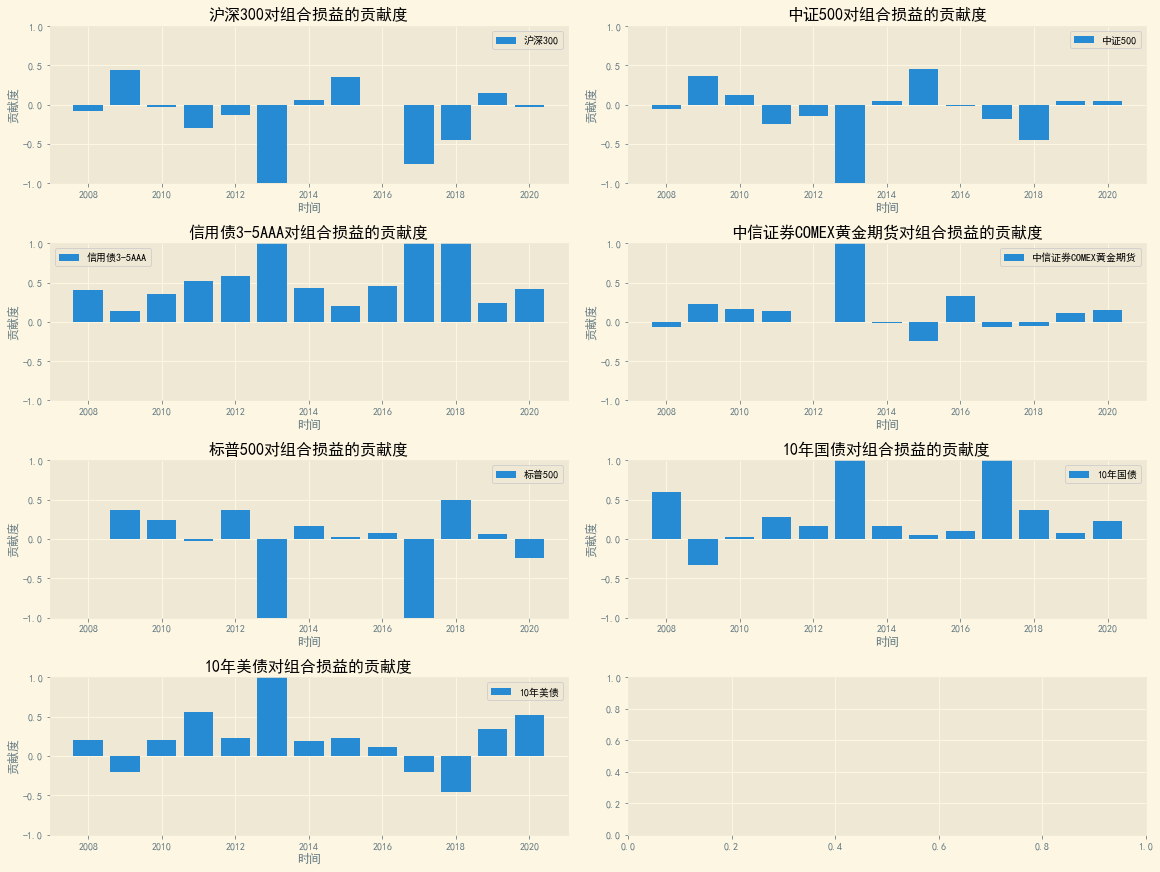

In [134]:
StatisticFunc.BarPlot(annualContrb_6, '铜油比D')

### 投资组合净值曲线

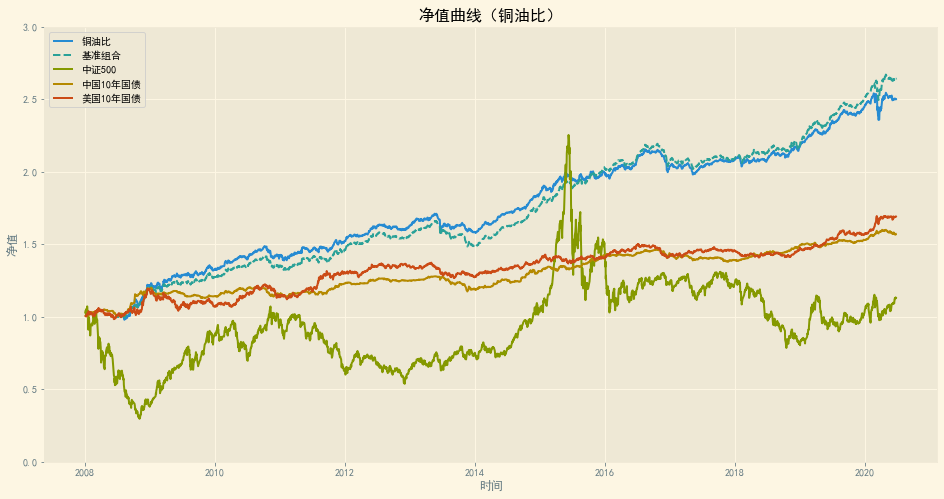

In [135]:
fig = plt.figure(figsize=(16, 8))

plt.plot(tradeDF_6.index, tradeDF_6['投资组合净值']/10000, label='铜油比')

# 基准参考
plt.plot(tradeDF.index, tradeDF['投资组合净值']/10000, ls='--', label='基准组合') 
plt.plot(cumReturns.index, cumReturns['中证500'], label='中证500')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='中国10年国债')
plt.plot(cumReturns.index, cumReturns['10年美债'], label='美国10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.ylim(0.0, 3.0)
plt.legend(loc='upper left')
plt.title('净值曲线（铜油比）')
plt.savefig('Pics/净值曲线（铜油比).png')

## 汇总比较

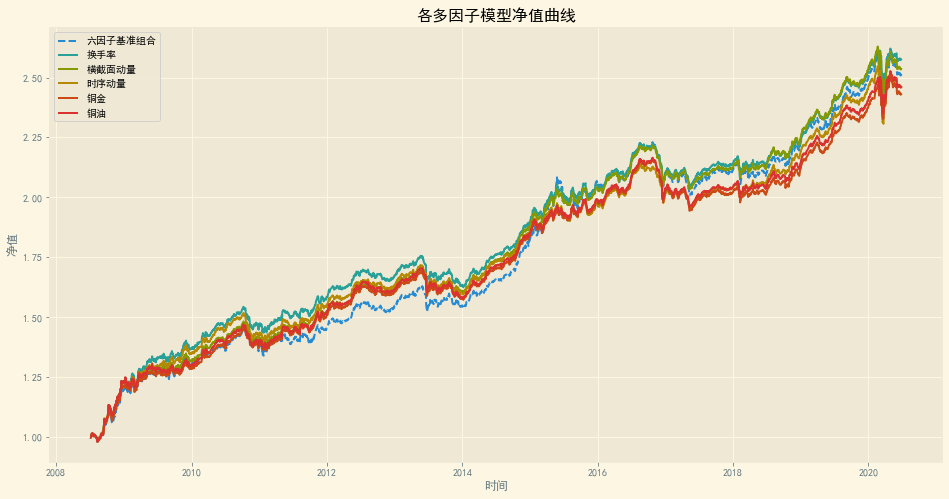

In [136]:
fig = plt.figure(figsize=(16, 8))


plt.plot(tradeDF_multi2.index, tradeDF_multi2['投资组合净值']/10000, ls='--', label='六因子基准组合')

plt.plot(tradeDF_1.index, tradeDF_1['投资组合净值']/10000, label='换手率')
plt.plot(tradeDF_2.index, tradeDF_2['投资组合净值']/10000, label='横截面动量')
plt.plot(tradeDF_3.index, tradeDF_3['投资组合净值']/10000, label='时序动量')
plt.plot(tradeDF_5.index, tradeDF_4['投资组合净值']/10000, label='铜金')
plt.plot(tradeDF_5.index, tradeDF_5['投资组合净值']/10000, label='铜油')


plt.xlabel('时间')
plt.ylabel('净值')
plt.legend(loc='upper left')
plt.title('各多因子模型净值曲线')
plt.savefig('Pics/各多因子模型净值曲线D.png')